<a href="https://colab.research.google.com/github/fabriziobasso/Colab_backup/blob/main/rain_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **S4E10 - Rain Forecast**

The table below shows the column names, their value formats, and their description.

Index| Features      |Format             |Description
-----|---------------|-------------------|-----------------------
1    |Date Time      |01.01.2009 00:10:00|Date-time reference
2    |p (mbar)       |996.52             |The pascal SI derived unit of pressure used to quantify internal pressure. Meteorological reports typically state atmospheric pressure in millibars.
3    |T (degC)       |-8.02              |Temperature in Celsius
4    |Tpot (K)       |265.4              |Temperature in Kelvin
5    |Tdew (degC)    |-8.9               |Temperature in Celsius relative to humidity. Dew Point is a measure of the absolute amount of water in the air, the DP is the temperature at which the air cannot hold all the moisture in it and water condenses.
6    |rh (%)         |93.3               |Relative Humidity is a measure of how saturated the air is with water vapor, the %RH determines the amount of water contained within collection objects.
7    |VPmax (mbar)   |3.33               |Saturation vapor pressure
8    |VPact (mbar)   |3.11               |Vapor pressure
9    |VPdef (mbar)   |0.22               |Vapor pressure deficit
10   |sh (g/kg)      |1.94               |Specific humidity
11   |H2OC (mmol/mol)|3.12               |Water vapor concentration
12   |rho (g/m ** 3) |1307.75            |Airtight
13   |wv (m/s)       |1.03               |Wind speed
14   |max. wv (m/s)  |1.75               |Maximum wind speed
15   |wd (deg)       |152.3              |Wind direction in degrees

## Intro: Problem Statement

<div class="container">
        <p class="mb-2">
            Analyze weather data over a 5-day period to identify patterns and correlations between various meteorological factors such as pressure, temperature, humidity, and rainfall. This can help in understanding how these variables influence daily weather conditions.
        </p>
        <h1 class="mb-2">Dataset Description</h1>
        <p class="mb-2">The dataset captures weather data over five days with the following features:</p>
        <ul class="mb-2">
            <li class="mb-2"><strong>day:</strong> Sequential day number.</li>
            <li class="mb-2"><strong>pressure (hPa):</strong> Atmospheric pressure measured in hectopascals.</li>
            <li class="mb-2"><strong>maxtemp (°C):</strong> Maximum temperature recorded on the day.</li>
            <li class="mb-2"><strong>temperature (°C):</strong> Average temperature of the day.</li>
            <li class="mb-2"><strong>mintemp (°C):</strong> Minimum temperature recorded on the day.</li>
            <li class="mb-2"><strong>dewpoint (°C):</strong> Temperature at which air becomes saturated with moisture.</li>
            <li class="mb-2"><strong>humidity (%):</strong> Relative humidity percentage.</li>
            <li class="mb-2"><strong>cloud (%):</strong> Cloud cover percentage.</li>
            <li class="mb-2"><strong>rainfall:</strong> Indicates if rainfall occurred ("yes"/"no").</li>
            <li class="mb-2"><strong>sunshine (hours):</strong> Total sunshine hours.</li>
            <li class="mb-2"><strong>winddirection (°):</strong> Direction of the wind in degrees.</li>
            <li class="mb-2"><strong>windspeed (km/h):</strong> Speed of the wind.</li>
        </ul>
        <p class="mb-2">
            This dataset is ideal for basic weather pattern analysis and visualization.
        </p>
    </div>

## 1.0 Libraries

In [1]:
%%capture
#!pip install -qq pytorch_tabnet
!pip install optuna
!pip install catboost
#!pip install optuna-integration-pytorch-tabnet

#from pytorch_tabnet.tab_model import TabNetRegressor

!pip install --upgrade category-encoders
!pip install optuna-integration
!pip install colorama
#!pip install pyfiglet
!pip install keras-tuner --upgrade
!pip install keras-nlp
!pip install BorutaShap
!pip install --upgrade scikit-learn
!pip install scikit-lego
!pip install skops

#from pytorch_tabnet.tab_model import TabNetRegressor

In [2]:
# Setup notebook
from pathlib import Path
import ipywidgets as widgets
import pandas as pd
import numpy as np
from pickle import load, dump
import json
import joblib
import skops.io as sio
#import calplot as cal

# Graphic Libraries:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg
# Set Style
sns.set_style("whitegrid",{"grid.linestyle":"--", 'grid.linewidth':0.2, 'grid.alpha':0.5});
sns.despine(left=True, bottom=True, top=False, right=False);
mpl.rcParams['figure.dpi'] = 120;
mpl.rc('axes', labelsize=12);
plt.rc('xtick',labelsize=10);
plt.rc('ytick',labelsize=10);

mpl.rcParams['axes.spines.top'] = False;
mpl.rcParams['axes.spines.right'] = False;
mpl.rcParams['axes.spines.left'] = True;

# Palette Setup
colors = ['#FB5B68','#FFEB48','#2676A1','#FFBDB0',]
colormap_0 = mpl.colors.LinearSegmentedColormap.from_list("",colors)
palette_1 = sns.color_palette("coolwarm", as_cmap=True)
palette_2 = sns.color_palette("YlOrBr", as_cmap=True)
palette_3 = sns.light_palette("red", as_cmap=True)
palette_4 = sns.color_palette("viridis", as_cmap=True)
palette_5 = sns.color_palette("rocket", as_cmap=True)
palette_6 = sns.color_palette("GnBu", as_cmap=True)
palette_7 = sns.color_palette("tab20c", as_cmap=False)
palette_8 = sns.color_palette("Set2", as_cmap=False)

palette_custom = ['#fbb4ae','#b3cde3','#ccebc5','#decbe4','#fed9a6','#ffffcc','#e5d8bd','#fddaec','#f2f2f2']
palette_9 = sns.color_palette(palette_custom, as_cmap=False)

# tool for Excel:
from openpyxl import load_workbook, Workbook
from openpyxl.drawing.image import Image
from openpyxl.styles import Border, Side, PatternFill, Font, GradientFill, Alignment
from openpyxl.worksheet.cell_range import CellRange

from openpyxl.formatting import Rule
from openpyxl.styles import Font, PatternFill, Border
from openpyxl.styles.differential import DifferentialStyle

# Bloomberg
#from xbbg import blp
from catboost import CatBoostRegressor, Pool, CatBoostClassifier
import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier
from xgboost.callback import EarlyStopping

import lightgbm as lgb
from lightgbm import (LGBMRegressor,
                      LGBMClassifier,
                      early_stopping,
                      record_evaluation,
                      log_evaluation)

# Time Management
from tqdm import tqdm
from datetime import date
from datetime import datetime
from pandas.tseries.offsets import BMonthEnd, QuarterEnd
from pandas.tseries.offsets import BDay # BDay is business day, not birthday...
import datetime as dt
import click
import glob
import os
import gc
import re
import string

from ipywidgets import AppLayout
from ipywidgets import Dropdown, Layout, HTML, AppLayout, VBox, Label, HBox, BoundedFloatText, interact, Output

#from my_func import *

import optuna
from optuna.integration import TFKerasPruningCallback
from optuna.trial import TrialState
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_contour

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import tensorflow as tf
import keras
from keras import ops
from keras import layers

from keras.layers import Input, LSTM, Dense, Lambda, RepeatVector, Reshape
from keras.models import Model
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError

from keras.utils import FeatureSpace, plot_model

# Import libraries for Hypertuning
import keras_tuner as kt
from keras_tuner.tuners import RandomSearch, GridSearch, BayesianOptimization

#from my_func import *

# preprocessing modules
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, RepeatedKFold, cross_val_score, cross_validate, GroupKFold, GridSearchCV, RepeatedStratifiedKFold, cross_val_predict
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer

from sklearn.preprocessing import (LabelEncoder,
                                   StandardScaler,
                                   MinMaxScaler,
                                   OrdinalEncoder,
                                   RobustScaler,
                                   PowerTransformer,
                                   OneHotEncoder,
                                   QuantileTransformer,
                                   PolynomialFeatures)

# metrics
import sklearn
#import skops.io as sio
from sklearn.metrics import (mean_squared_error,
                             root_mean_squared_error,
                             root_mean_squared_log_error,
                             r2_score,
                             mean_absolute_error,
                             mean_absolute_percentage_error,
                             classification_report,
                             confusion_matrix,
                             ConfusionMatrixDisplay,
                             multilabel_confusion_matrix,
                             accuracy_score,
                             roc_auc_score,
                             auc,
                             roc_curve,
                             log_loss,
                             make_scorer)
# modeling algos
from sklearn.linear_model import (LogisticRegression,
                                  Lasso,
                                  ridge_regression,
                                  LinearRegression,
                                  Ridge,
                                  RidgeCV,
                                  ElasticNet,
                                  BayesianRidge,
                                  HuberRegressor,
                                  TweedieRegressor,
                                  QuantileRegressor,
                                  ARDRegression,
                                  TheilSenRegressor,
                                  PoissonRegressor,
                                  GammaRegressor)

from sklearn.ensemble import (AdaBoostRegressor,
                              AdaBoostClassifier,
                              RandomForestRegressor,
                              RandomForestClassifier,
                              VotingRegressor,
                              GradientBoostingRegressor,
                              GradientBoostingClassifier,
                              StackingRegressor,
                              StackingClassifier,
                              HistGradientBoostingClassifier,
                              HistGradientBoostingRegressor,
                              ExtraTreesClassifier)

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
%matplotlib inline

from sklearn.linear_model import LinearRegression
import numpy as np
import seaborn as sns
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

from sklearn.multioutput import RegressorChain
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor

import itertools
import warnings
from openpyxl import load_workbook

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

import statsmodels.api as sm
from pylab import rcParams
import scipy.stats as ss

from category_encoders.cat_boost import CatBoostEncoder
from category_encoders.wrapper import PolynomialWrapper
from category_encoders.count import CountEncoder
from category_encoders import TargetEncoder

warnings.filterwarnings('ignore')
#import pyfiglet
#plt.style.use('fivethirtyeight')

<Figure size 640x480 with 0 Axes>

In [3]:
sns.set({"axes.facecolor"       : "#ffffff",
         "figure.facecolor"     : "#ffffff",
         "axes.edgecolor"       : "#000000",
         "grid.color"           : "#ffffff",
         "font.family"          : ['Cambria'],
         "axes.labelcolor"      : "#000000",
         "xtick.color"          : "#000000",
         "ytick.color"          : "#000000",
         "grid.linewidth"       : 0.5,
         'grid.alpha'           :0.5,
         "grid.linestyle"       : "--",
         "axes.titlecolor"      : 'black',
         'axes.titlesize'       : 12,
#         'axes.labelweight'     : "bold",
         'legend.fontsize'      : 7.0,
         'legend.title_fontsize': 7.0,
         'font.size'            : 7.5,
         'xtick.labelsize'      : 7.5,
         'ytick.labelsize'      : 7.5,
        });

sns.set_style("whitegrid",{"grid.linestyle":"--", 'grid.linewidth':0.2, 'grid.alpha':0.5})
# Set Style
mpl.rcParams['figure.dpi'] = 120;

# import font colors
from colorama import Fore, Style, init

# Making sklearn pipeline outputs as dataframe:-
pd.set_option('display.max_columns', 100);
pd.set_option('display.max_rows', 50);

sns.despine(left=True, bottom=True, top=False, right=False)

mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = True

init(autoreset=True)

<Figure size 960x660 with 0 Axes>

In [4]:
from tqdm import tqdm
from itertools import product

import numpy as np
import pandas as pd
import gc
import matplotlib.pyplot as plt
import seaborn as sns

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

from sklearn.model_selection import GroupKFold
from sklearn.impute import SimpleImputer
import torch

import warnings
warnings.filterwarnings("ignore")

# Connect to Colab:#
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2.0 Loading and Preprocessing Data


In [5]:
df_subm = pd.read_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E3/sample_submission.csv", index_col=0)

validation = pd.read_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E3/X_enc_y_old_all.csv")
train = pd.read_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E3/X_enc_y_new_all.csv")
test = pd.read_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E3/test_enc_all.csv")

In [6]:
#df_train_old.isna().sum()

In [7]:
train.shape, test.shape, validation.shape

((2190, 26), (730, 25), (365, 26))

In [8]:
df_all_new = pd.concat([train, test], axis=0)
print(df_all_new.shape)
df_all_new.head(3)

(2920, 26)


,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,windspeed,Wdsx,Wdsy,Year_sin,Year_cos,sem_sin,sem_cos,m4_sin,m4_cos,m6_sin,m6_cos,m8_sin,m8_cos,temp_diff,dewpoint_spread,range_dist_cloud,cloud_Humidity_Interaction,rainfall
0,0.654955,21.2,-0.629297,19.9,-0.183091,0.638922,0.692700,-0.745242,17.2,0.266192,0.404027,0.017213,0.999852,0.034422,0.999407,0.051620,0.998667,0.103102,0.994671,0.137279,0.990532,-1.885535,-1.201297,-1.147765,0.202762,1.0
1,1.019030,16.2,-1.329863,15.8,-0.924418,1.616306,0.853347,-1.044309,21.9,0.627866,0.523115,0.034422,0.999407,0.068802,0.997630,0.103102,0.994671,0.205104,0.978740,0.271958,0.962309,-2.468657,-1.047000,-1.714207,1.785597,1.0
2,1.816533,19.4,-1.481337,14.6,-2.054941,-0.827153,-1.502805,1.212287,18.1,0.107086,0.537809,0.051620,0.998667,0.103102,0.994671,0.154309,0.988023,0.304921,0.952378,0.401488,0.915864,0.382156,1.678918,-1.102818,-1.006968,1.0


In [9]:
df_all_new.tail(3)

,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,windspeed,Wdsx,Wdsy,Year_sin,Year_cos,sem_sin,sem_cos,m4_sin,m4_cos,m6_sin,m6_cos,m8_sin,m8_cos,temp_diff,dewpoint_spread,range_dist_cloud,cloud_Humidity_Interaction,rainfall
727,1.573820,21.0,-1.026915,17.0,-0.905885,1.249787,1.121091,-1.044309,21.9,0.627866,0.523115,-3.442161e-02,0.999407,-6.880243e-02,0.997630,-1.031017e-01,0.994671,-2.051045e-01,0.978740,-2.719582e-01,0.962309,-0.136173,-0.275514,1.099351,1.826335,NaN
728,0.134842,21.0,-0.742902,19.7,-0.108959,1.494133,0.960444,-1.044309,39.5,1.374918,1.376817,-1.721336e-02,0.999852,-3.442161e-02,0.999407,-5.161967e-02,0.998667,-1.031017e-01,0.994671,-1.372788e-01,0.990532,-1.885537,-1.715621,-1.049108,1.789645,NaN
729,1.261754,22.2,-0.970113,17.0,-1.313614,-0.338461,0.746249,-0.989933,50.6,1.368967,2.235567,-2.449294e-16,1.000000,-4.898587e-16,1.000000,-7.347881e-16,1.000000,-1.469576e-15,1.000000,-1.959435e-15,1.000000,0.641322,1.010296,1.462053,1.115856,NaN


In [10]:
step = 1

past = 7
future = 0
learning_rate = 0.01
batch_size = 128
epochs = 21

test_final = df_all_new.iloc[2190-past+1:,:]

In [11]:
# Train data
x_train = train.iloc[:,:-1].values
y_train = train.iloc[past-1:,-1].values.reshape(-1,1)
print(x_train.shape, y_train.shape)
# Valid Data
x_valid = validation.iloc[:,:-1].values
y_valid = validation.iloc[past-1:,-1].values.reshape(-1,1)
print(x_valid.shape, y_valid.shape)
# Test Data
x_test = test_final.iloc[:,:-1].values
y_test = test_final.iloc[past-1:,-1].values.reshape(-1,1)
print(x_test.shape, y_test.shape)

(2190, 25) (2184, 1)
(365, 25) (359, 1)
(736, 25) (730, 1)


## 3.0 Dataset Management Functions

####  **3.1 Train Dataset**

In [12]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
                                                                    x_train,
                                                                    y_train,
                                                                    sequence_length=7,
                                                                    sampling_rate=step,
                                                                    batch_size=10000,
                                                                    shuffle=True
                                                                 )


for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (2184, 7, 25)
Target shape: (2184, 1)


In [13]:
# Find indices of 0s
indices_of_zeros = np.where(targets.numpy() == 0)[0]

# Find indices of 1s
indices_of_ones = np.where(targets.numpy() == 1)[0]

In [14]:
indices_of_zeros.shape,indices_of_ones.shape

((539,), (1645,))

* **TRAIN DATASET - INFINITE SAMPLING**

* **GOAL: Oversample the minority class**
A related approach would be to resample the dataset by oversampling the minority class.

In [15]:
pos_features = inputs.numpy()[indices_of_ones]
neg_features = inputs.numpy()[indices_of_zeros]

pos_labels = targets.numpy()[indices_of_ones]
neg_labels = targets.numpy()[indices_of_zeros]

pos_features.shape,pos_labels.shape,neg_features.shape,neg_labels.shape

((1645, 7, 25), (1645, 1), (539, 7, 25), (539, 1))

In [16]:
BUFFER_SIZE = 100000

def make_ds(features, labels):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

In [17]:
for num, (features, label) in enumerate(pos_ds.take(10)):
  #print("Features:\n", features.numpy())
  #print()
  print(f"Label sample {num}: ", label.numpy())

Label sample 0:  [1]
Label sample 1:  [1]
Label sample 2:  [1]
Label sample 3:  [1]
Label sample 4:  [1]
Label sample 5:  [1]
Label sample 6:  [1]
Label sample 7:  [1]
Label sample 8:  [1]
Label sample 9:  [1]


In [18]:
resampled_ds = tf.data.Dataset.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(64).prefetch(2)

In [19]:
for features, label in resampled_ds.take(1):
  print(label.numpy().mean())

0.484375


#### **3.2 Validation Dataset**

In [20]:
dataset_validation = keras.preprocessing.timeseries_dataset_from_array(
                                                                    x_valid,
                                                                    y_valid,
                                                                    sequence_length=7,
                                                                    sampling_rate=step,
                                                                    batch_size=64,
                                                                    shuffle=False
                                                                 )


for batch in dataset_validation.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (64, 7, 25)
Target shape: (64, 1)


#### **3.3 Test Dataset**

In [21]:
dataset_test = keras.preprocessing.timeseries_dataset_from_array(
                                                                    x_test,
                                                                    y_test,
                                                                    sequence_length=7,
                                                                    sampling_rate=step,
                                                                    batch_size=64,
                                                                    shuffle=False
                                                                 )


for batch in dataset_test.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (64, 7, 25)
Target shape: (64, 1)


## 4.0 NN Models:

In [22]:
def plot_metrics(history):
  metrics = ['loss', 'auc']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0,1])
    else:
      plt.ylim([0,1])

    plt.legend()

def plot_cm(labels, predictions, threshold=0.5):
  cm = confusion_matrix(labels, predictions > threshold)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(threshold))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

In [23]:
step = 1

past = 7
future = 0
learning_rate = 0.01
batch_size = 64
epochs = 101

In [24]:
METRICS = [
          keras.metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
          keras.metrics.AUC(name='auc'),
          keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
          ]

### 4.1 LSTM v0

In [25]:
def make_model(metrics=METRICS, units=[32,32], output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)

  data = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]), name="input_layer")
  data_noised = keras.layers.GaussianNoise(stddev=0.05, name="noise_layer")(data)
  lstm_out = keras.layers.LSTM(units[0], return_sequences=True, name="lstm_0")(data_noised)
  lstm_out = keras.layers.LSTM(units[1], name="lstm_1")(lstm_out)
  outputs = keras.layers.Dense(1, activation='sigmoid',bias_initializer=output_bias, name="output")(lstm_out)

  model = keras.Model(inputs=data, outputs=outputs, name="LSTM_v0")

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

model= make_model(units=[64,64])

# Reset the bias to zero, since this dataset is balanced.
output_layer = model.layers[-1]
output_layer.bias.assign([0])

model.summary()

Model: "LSTM_v0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 7, 25)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ noise_layer (GaussianNoise)          │ (None, 7, 25)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_0 (LSTM)                        │ (None, 7, 64)               │          23,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 56,129 (219.25 KB)

 Trainable params: 56,129 (219.25 KB)

 Non-trainable params: 0 (0.00 B)

#### Fit the model

In [26]:
pos = pos_features.shape[0]
neg = neg_features.shape[0]
print(pos,neg)
resampled_steps_per_epoch = int(np.ceil(2.0*pos/batch_size))
resampled_steps_per_epoch

1645 539


52

In [27]:
resampled_history = model.fit(
                              resampled_ds,
                              epochs=epochs,
                              steps_per_epoch=52,
                              callbacks=[keras.callbacks.ReduceLROnPlateau(patience=5, factor=0.5),
                                         keras.callbacks.EarlyStopping(patience=31, restore_best_weights=True, monitor="val_auc",
                                                                      start_from_epoch=3, mode="max")],
                              validation_data=dataset_validation
                              )

Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - auc: 0.5992 - cross entropy: 0.6757 - loss: 0.6757 - prc: 0.6135 - val_auc: 0.7918 - val_cross entropy: 0.5733 - val_loss: 0.5733 - val_prc: 0.8809 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - auc: 0.8316 - cross entropy: 0.5193 - loss: 0.5193 - prc: 0.8121 - val_auc: 0.8748 - val_cross entropy: 0.4159 - val_loss: 0.4159 - val_prc: 0.9265 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - auc: 0.8864 - cross entropy: 0.4251 - loss: 0.4251 - prc: 0.8693 - val_auc: 0.8779 - val_cross entropy: 0.4890 - val_loss: 0.4890 - val_prc: 0.9305 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - auc: 0.8964 - cross entropy: 0.4050 - loss: 0.4050 - prc: 0.8919 - val_auc: 0.8819 - val_cross entropy: 0.4618 - val_loss: 0.4618 - val_prc: 0.9365 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - auc: 0.9030 - cross entropy: 0.3933 - los

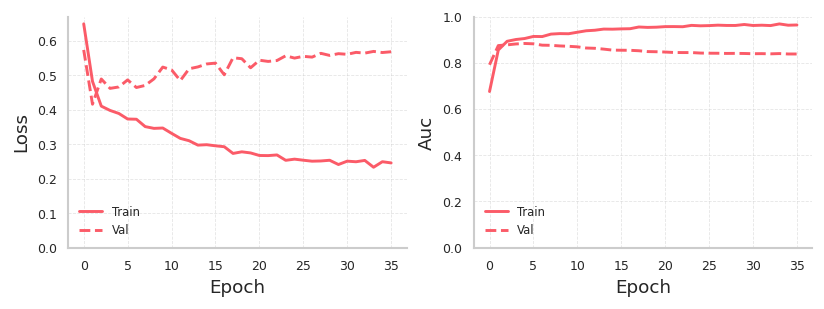

In [28]:
plot_metrics(resampled_history)

#### Evaluate Model:

In [29]:
train_predictions_resampled = model.predict(dataset_train)
valid_predictions_resampled = model.predict(dataset_validation)
test_predictions_resampled = model.predict(dataset_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step


Legitimate Transactions Detected (True Negatives):  90
Legitimate Transactions Incorrectly Detected (False Positives):  26
Fraudulent Transactions Missed (False Negatives):  47
Fraudulent Transactions Detected (True Positives):  196
Total Fraudulent Transactions:  243


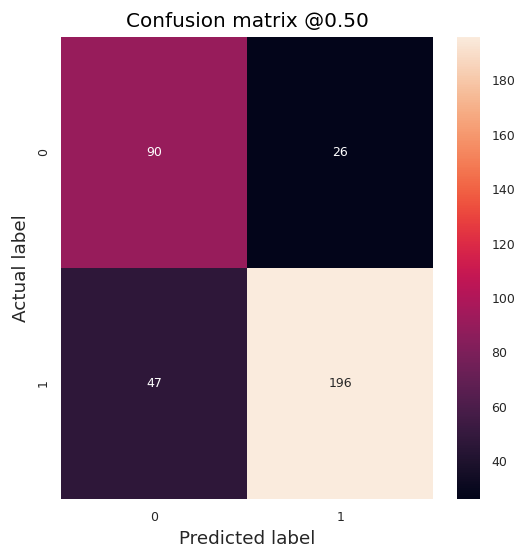

In [ ]:
plot_cm(y_valid, valid_predictions_resampled)

Legitimate Transactions Detected (True Negatives):  93
Legitimate Transactions Incorrectly Detected (False Positives):  23
Fraudulent Transactions Missed (False Negatives):  60
Fraudulent Transactions Detected (True Positives):  183
Total Fraudulent Transactions:  243


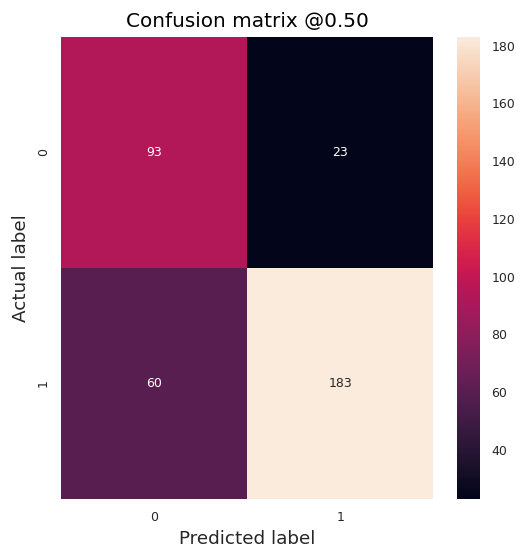

In [31]:
plot_cm(y_valid, valid_predictions_resampled)

In [32]:
df_subm["rainfall"] = test_predictions_resampled
df_subm.to_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E3/submission_lstm_v2_all_data.csv")

### 4.1 LSTM-Tab v0

In [25]:
def make_model(metrics=METRICS, units=[32,32],units_tab=[64,32], output_bias=None, gn=0.025, activation="relu", do=0.3):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)

  data = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]), name="input_layer")
  data_tabular = data[:, 6, :]
  # LSTM Section
  data_noised = keras.layers.GaussianNoise(stddev=gn, name="noise_layer")(data)
  lstm_out = keras.layers.LSTM(units[0], return_sequences=True, name="lstm_0",)(data_noised)
  lstm_out = keras.layers.LSTM(units[1], name="lstm_1")(lstm_out)

  # Tabular Section
  tabx = keras.layers.Dense(units_tab[0], name="dense_0")(data_tabular)
  tabx = keras.layers.BatchNormalization(name="batch_0")(tabx)
  tabx = keras.layers.Activation(activation, name="act_0")(tabx)
  tabx = keras.layers.Dropout(do, name="do_0")(tabx)
  tabx = keras.layers.Dense(units_tab[1], activation='relu', name="dense_1")(tabx)
  tabx = keras.layers.BatchNormalization(name="batch_1")(tabx)
  tabx = keras.layers.Activation(activation, name="act_1")(tabx)
  tabx = keras.layers.Dropout(do, name="do_1")(tabx)

  # Concatenate
  x = keras.layers.Concatenate(name="concat")([lstm_out, tabx,data_tabular])
  outputs = keras.layers.Dense(1, activation='sigmoid',bias_initializer=output_bias, name="output")(x)

  model = keras.Model(inputs=data, outputs=outputs, name="LSTM_v0")

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

model= make_model(units=[64,32],output_bias=0)

# Reset the bias to zero, since this dataset is balanced.
output_layer = model.layers[-1]
output_layer.bias.assign([0])

model.summary()

Model: "LSTM_v0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 7, 25)          │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item (GetItem)        │ (None, 25)             │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_0 (Dense)           │ (None, 64)             │          1,664 │ get_item[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_0                   │ (None, 64)             │            256 │ dense_0[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ act_0 (Activation)        │ (None, 64)             │              0 │ batch_0[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ do_0 (Dropout)            │ (None, 64)             │              0 │ act_0[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 32)             │          2,080 │ do_0[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ noise_layer               │ (None, 7, 25)          │              0 │ input_layer[0][0]      │
│ (GaussianNoise)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_1                   │ (None, 32)             │            128 │ dense_1[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_0 (LSTM)             │ (None, 7, 64)          │         23,040 │ noise_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ act_1 (Activation)        │ (None, 32)             │              0 │ batch_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ (None, 32)             │         12,416 │ lstm_0[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ do_1 (Dropout)            │ (None, 32)             │              0 │ act_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concat (Concatenate)      │ (None, 89)             │              0 │ lstm_1[0][0],          │
│                           │                        │                │ do_1[0][0],            │
│                           │                        │                │ get_item[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output (Dense)            │ (None, 1)              │             90 │ concat[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 39,674 (154.98 KB)

 Trainable params: 39,482 (154.23 KB)

 Non-trainable params: 192 (768.00 B)

#### Optuna Optimization

In [26]:
def objective_nn(trial, train_data, validation_data, model=make_model, use_gpu=False, rs=42, fit_scaling=False):

    model_class = model

    params = {
              'units': [trial.suggest_categorical('units_0', [128,64]),trial.suggest_categorical('units_1', [64,32])],
              'units_tab': [trial.suggest_categorical('units_tab_0', [256, 128, 64]),trial.suggest_categorical('units_tab_1', [128, 64,32])],
              'activation': trial.suggest_categorical('activation', ["relu","selu","gelu","silu"]),
              'gn': trial.suggest_float('gn', 0.01, 0.1, step=0.01),
              'do': trial.suggest_float('do', 0.20, 0.45, step=0.01)
              }

    auc_score = []

    keras.utils.set_random_seed(rs)
    model = model_class(**params)

    # Fit the model
    model.fit(train_data,
              validation_data=validation_data,
              epochs=epochs,
              steps_per_epoch=52,
              callbacks=[keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.3, monitor="val_auc", min_lr=0.000001, mode="max"),
                         keras.callbacks.EarlyStopping(patience=31, restore_best_weights=True, monitor="val_auc",
                                                       start_from_epoch=3, mode="max")]
              )

    # Make predictions on the validation set
    y_pred = model.predict(validation_data)

    # Calculate the RMSE for the current fold
    rmse_scores = roc_auc_score(y_valid, y_pred)

    return rmse_scores

In [27]:
# Step 2: Tuning Hyperparameters with Optuna
def tune_hyperparameters(train_data, validation_data, model_class, n_trials, use_gpu=True):  #use_gpu
    study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))
    study.optimize(lambda trial: objective_nn(trial, train_data=train_data, validation_data=validation_data, model=make_model, use_gpu=use_gpu), n_trials=n_trials)
    return study  # Return the study object

In [ ]:
nn_study = tune_hyperparameters(train_data=resampled_ds,validation_data=dataset_validation, model_class=make_model, n_trials=101, use_gpu=False)
#save_results(cat_study, TabNetClassifier, "tabnet_ext")
cat_params = nn_study.best_params

cat_params

[I 2025-03-06 23:16:13,297] A new study created in memory with name: no-name-77e61ece-bac7-4c43-9006-dd48810f051b


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - auc: 0.5576 - cross entropy: 1.8199 - loss: 1.8199 - prc: 0.5818 - val_auc: 0.8409 - val_cross entropy: 0.4688 - val_loss: 0.4688 - val_prc: 0.9031 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - auc: 0.8571 - cross entropy: 0.4866 - loss: 0.4866 - prc: 0.8266 - val_auc: 0.8682 - val_cross entropy: 0.4466 - val_loss: 0.4466 - val_prc: 0.9277 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - auc: 0.8786 - cross entropy: 0.4438 - loss: 0.4438 - prc: 0.8691 - val_auc: 0.8765 - val_cross entropy: 0.4252 - val_loss: 0.4252 - val_prc: 0.9336 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - auc: 0.8790 - cross entropy: 0.4436 - loss: 0.4436 - prc: 0.8558 - val_auc: 0.8793 - val_cross entropy: 0.4100 - val_loss: 0.4100 - val_prc: 0.9359 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - auc: 0.8757 - cross entropy: 0.4466 - los

[I 2025-03-06 23:17:35,428] Trial 0 finished with value: 0.8833191428976869 and parameters: {'units_0': 64, 'units_1': 32, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'selu', 'gn': 0.01, 'do': 0.35}. Best is trial 0 with value: 0.8833191428976869.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 11s 82ms/step - auc: 0.6409 - cross entropy: 1.3865 - loss: 1.8084 - prc: 0.7266 - val_auc: 0.8570 - val_cross entropy: 0.5429 - val_loss: 0.5429 - val_prc: 0.9182 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - auc: 0.8580 - cross entropy: 0.4741 - loss: 0.4741 - prc: 0.8355 - val_auc: 0.8773 - val_cross entropy: 0.4044 - val_loss: 0.4044 - val_prc: 0.9309 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - auc: 0.8751 - cross entropy: 0.4458 - loss: 0.4458 - prc: 0.8586 - val_auc: 0.8793 - val_cross entropy: 0.3967 - val_loss: 0.3967 - val_prc: 0.9332 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - auc: 0.9022 - cross entropy: 0.3950 - loss: 0.3950 - prc: 0.8964 - val_auc: 0.8793 - val_cross entropy: 0.4197 - val_loss: 0.4197 - val_prc: 0.9338 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - auc: 0.9001 - cross entropy: 0.3982 - lo

[I 2025-03-06 23:19:14,915] Trial 1 finished with value: 0.8847381864623244 and parameters: {'units_0': 128, 'units_1': 32, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'gelu', 'gn': 0.05, 'do': 0.22}. Best is trial 1 with value: 0.8847381864623244.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - auc: 0.7746 - cross entropy: 0.7268 - loss: 0.8710 - prc: 0.7617 - val_auc: 0.8531 - val_cross entropy: 0.4395 - val_loss: 0.4395 - val_prc: 0.9128 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - auc: 0.8597 - cross entropy: 0.4923 - loss: 0.4923 - prc: 0.8299 - val_auc: 0.8783 - val_cross entropy: 0.4984 - val_loss: 0.4984 - val_prc: 0.9331 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - auc: 0.8709 - cross entropy: 0.4659 - loss: 0.4659 - prc: 0.8586 - val_auc: 0.8776 - val_cross entropy: 0.5291 - val_loss: 0.5291 - val_prc: 0.9289 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - auc: 0.8726 - cross entropy: 0.4536 - loss: 0.4536 - prc: 0.8595 - val_auc: 0.8862 - val_cross entropy: 0.5771 - val_loss: 0.5771 - val_prc: 0.9378 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - auc: 0.8828 - cross entropy: 0.4393 - los

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step


[I 2025-03-06 23:20:46,094] Trial 2 finished with value: 0.8884986519086135 and parameters: {'units_0': 64, 'units_1': 32, 'units_tab_0': 256, 'units_tab_1': 128, 'activation': 'selu', 'gn': 0.09999999999999999, 'do': 0.37}. Best is trial 2 with value: 0.8884986519086135.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - auc: 0.6775 - cross entropy: 0.8356 - loss: 1.0188 - prc: 0.7286 - val_auc: 0.8379 - val_cross entropy: 0.4957 - val_loss: 0.4957 - val_prc: 0.9001 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - auc: 0.8633 - cross entropy: 0.4709 - loss: 0.4709 - prc: 0.8318 - val_auc: 0.8380 - val_cross entropy: 0.5327 - val_loss: 0.5327 - val_prc: 0.8975 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - auc: 0.8644 - cross entropy: 0.4645 - loss: 0.4645 - prc: 0.8482 - val_auc: 0.8528 - val_cross entropy: 0.4650 - val_loss: 0.4650 - val_prc: 0.9153 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - auc: 0.8845 - cross entropy: 0.4313 - loss: 0.4313 - prc: 0.8727 - val_auc: 0.8668 - val_cross entropy: 0.4580 - val_loss: 0.4580 - val_prc: 0.9263 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - auc: 0.8872 - cross entropy: 0.4237 - loss

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


[I 2025-03-06 23:22:17,729] Trial 3 finished with value: 0.8891372215127005 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 64, 'units_tab_1': 128, 'activation': 'silu', 'gn': 0.05, 'do': 0.26}. Best is trial 3 with value: 0.8891372215127005.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - auc: 0.6552 - cross entropy: 0.9166 - loss: 1.1206 - prc: 0.6621 - val_auc: 0.8022 - val_cross entropy: 0.5584 - val_loss: 0.5584 - val_prc: 0.8708 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - auc: 0.8064 - cross entropy: 0.5371 - loss: 0.5371 - prc: 0.7743 - val_auc: 0.8786 - val_cross entropy: 0.5246 - val_loss: 0.5246 - val_prc: 0.9305 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - auc: 0.8856 - cross entropy: 0.4260 - loss: 0.4260 - prc: 0.8710 - val_auc: 0.8855 - val_cross entropy: 0.4133 - val_loss: 0.4133 - val_prc: 0.9373 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - auc: 0.8886 - cross entropy: 0.4224 - loss: 0.4224 - prc: 0.8746 - val_auc: 0.8916 - val_cross entropy: 0.4754 - val_loss: 0.4754 - val_prc: 0.9438 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - auc: 0.8946 - cross entropy: 0.4082 - loss

[I 2025-03-06 23:24:08,569] Trial 4 finished with value: 0.8921881651766709 and parameters: {'units_0': 128, 'units_1': 64, 'units_tab_0': 64, 'units_tab_1': 32, 'activation': 'relu', 'gn': 0.01, 'do': 0.31}. Best is trial 4 with value: 0.8921881651766709.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - auc: 0.5707 - cross entropy: 2.1217 - loss: 2.8528 - prc: 0.5687 - val_auc: 0.7764 - val_cross entropy: 2.9006 - val_loss: 2.9006 - val_prc: 0.8822 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - auc: 0.8797 - cross entropy: 0.4395 - loss: 0.4395 - prc: 0.8634 - val_auc: 0.8723 - val_cross entropy: 1.0190 - val_loss: 1.0190 - val_prc: 0.9303 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - auc: 0.8927 - cross entropy: 0.4138 - loss: 0.4138 - prc: 0.8799 - val_auc: 0.8787 - val_cross entropy: 0.6401 - val_loss: 0.6401 - val_prc: 0.9332 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - auc: 0.8912 - cross entropy: 0.4149 - loss: 0.4149 - prc: 0.8883 - val_auc: 0.8778 - val_cross entropy: 0.5902 - val_loss: 0.5902 - val_prc: 0.9322 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - auc: 0.8954 - cross entropy: 0.4071 - loss

[I 2025-03-06 23:25:29,643] Trial 5 finished with value: 0.8826096211153682 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 256, 'units_tab_1': 64, 'activation': 'silu', 'gn': 0.02, 'do': 0.29000000000000004}. Best is trial 4 with value: 0.8921881651766709.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - auc: 0.7457 - cross entropy: 0.7691 - loss: 0.9387 - prc: 0.7760 - val_auc: 0.8524 - val_cross entropy: 0.5200 - val_loss: 0.5200 - val_prc: 0.9095 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - auc: 0.8490 - cross entropy: 0.5214 - loss: 0.5214 - prc: 0.8141 - val_auc: 0.8608 - val_cross entropy: 0.4188 - val_loss: 0.4188 - val_prc: 0.9163 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - auc: 0.8738 - cross entropy: 0.4567 - loss: 0.4567 - prc: 0.8562 - val_auc: 0.8757 - val_cross entropy: 0.4069 - val_loss: 0.4069 - val_prc: 0.9324 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - auc: 0.8651 - cross entropy: 0.4680 - loss: 0.4680 - prc: 0.8509 - val_auc: 0.8810 - val_cross entropy: 0.4084 - val_loss: 0.4084 - val_prc: 0.9354 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - auc: 0.8682 - cross entropy: 0.4618 - los

[I 2025-03-06 23:27:32,354] Trial 6 finished with value: 0.8844189016602809 and parameters: {'units_0': 128, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 128, 'activation': 'selu', 'gn': 0.04, 'do': 0.42000000000000004}. Best is trial 4 with value: 0.8921881651766709.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - auc: 0.6196 - cross entropy: 1.5885 - loss: 2.0519 - prc: 0.6985 - val_auc: 0.8277 - val_cross entropy: 0.4850 - val_loss: 0.4850 - val_prc: 0.8822 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - auc: 0.7713 - cross entropy: 0.5785 - loss: 0.5785 - prc: 0.7596 - val_auc: 0.8688 - val_cross entropy: 0.4107 - val_loss: 0.4107 - val_prc: 0.9230 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - auc: 0.8434 - cross entropy: 0.4957 - loss: 0.4957 - prc: 0.8223 - val_auc: 0.8774 - val_cross entropy: 0.4108 - val_loss: 0.4108 - val_prc: 0.9297 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - auc: 0.8810 - cross entropy: 0.4344 - loss: 0.4344 - prc: 0.8695 - val_auc: 0.8856 - val_cross entropy: 0.4322 - val_loss: 0.4322 - val_prc: 0.9396 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - auc: 0.8841 - cross entropy: 0.4285 - los

[I 2025-03-06 23:28:47,491] Trial 7 finished with value: 0.8862636582943096 and parameters: {'units_0': 64, 'units_1': 32, 'units_tab_0': 64, 'units_tab_1': 32, 'activation': 'relu', 'gn': 0.08, 'do': 0.36}. Best is trial 4 with value: 0.8921881651766709.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step - auc: 0.5693 - cross entropy: 2.1157 - loss: 2.8485 - prc: 0.5681 - val_auc: 0.7808 - val_cross entropy: 2.7270 - val_loss: 2.7270 - val_prc: 0.8855 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - auc: 0.8825 - cross entropy: 0.4329 - loss: 0.4329 - prc: 0.8671 - val_auc: 0.8741 - val_cross entropy: 0.8909 - val_loss: 0.8909 - val_prc: 0.9310 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - auc: 0.9008 - cross entropy: 0.3986 - loss: 0.3986 - prc: 0.8903 - val_auc: 0.8786 - val_cross entropy: 0.5764 - val_loss: 0.5764 - val_prc: 0.9341 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - auc: 0.9072 - cross entropy: 0.3844 - loss: 0.3844 - prc: 0.9051 - val_auc: 0.8824 - val_cross entropy: 0.5768 - val_loss: 0.5768 - val_prc: 0.9347 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - auc: 0.9018 - cross entropy: 0.3941 - loss

[I 2025-03-06 23:30:18,494] Trial 8 finished with value: 0.8824322406697886 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 256, 'units_tab_1': 64, 'activation': 'gelu', 'gn': 0.060000000000000005, 'do': 0.23}. Best is trial 4 with value: 0.8921881651766709.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 13s 108ms/step - auc: 0.5373 - cross entropy: 2.0043 - loss: 2.7067 - prc: 0.5462 - val_auc: 0.7358 - val_cross entropy: 3.1235 - val_loss: 3.1235 - val_prc: 0.8642 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - auc: 0.8327 - cross entropy: 0.5094 - loss: 0.5094 - prc: 0.8043 - val_auc: 0.8527 - val_cross entropy: 1.2909 - val_loss: 1.2909 - val_prc: 0.9132 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - auc: 0.8751 - cross entropy: 0.4441 - loss: 0.4441 - prc: 0.8570 - val_auc: 0.8722 - val_cross entropy: 0.7194 - val_loss: 0.7194 - val_prc: 0.9265 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - auc: 0.8750 - cross entropy: 0.4442 - loss: 0.4442 - prc: 0.8610 - val_auc: 0.8807 - val_cross entropy: 0.5606 - val_loss: 0.5606 - val_prc: 0.9316 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - auc: 0.8875 - cross entropy: 0.4256 - lo

[I 2025-03-06 23:32:49,255] Trial 9 finished with value: 0.8825386689371364 and parameters: {'units_0': 128, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 64, 'activation': 'relu', 'gn': 0.09999999999999999, 'do': 0.32}. Best is trial 4 with value: 0.8921881651766709.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 13s 98ms/step - auc: 0.6384 - cross entropy: 0.9450 - loss: 1.1655 - prc: 0.6387 - val_auc: 0.7835 - val_cross entropy: 0.6233 - val_loss: 0.6233 - val_prc: 0.8620 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - auc: 0.7921 - cross entropy: 0.5558 - loss: 0.5558 - prc: 0.7528 - val_auc: 0.8778 - val_cross entropy: 0.4383 - val_loss: 0.4383 - val_prc: 0.9318 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - auc: 0.8844 - cross entropy: 0.4289 - loss: 0.4289 - prc: 0.8696 - val_auc: 0.8816 - val_cross entropy: 0.4157 - val_loss: 0.4157 - val_prc: 0.9343 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - auc: 0.8890 - cross entropy: 0.4238 - loss: 0.4238 - prc: 0.8722 - val_auc: 0.8869 - val_cross entropy: 0.4622 - val_loss: 0.4622 - val_prc: 0.9385 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - auc: 0.8923 - cross entropy: 0.4139 - los

[I 2025-03-06 23:37:20,354] Trial 10 finished with value: 0.8872569887895558 and parameters: {'units_0': 128, 'units_1': 64, 'units_tab_0': 64, 'units_tab_1': 32, 'activation': 'relu', 'gn': 0.03, 'do': 0.45}. Best is trial 4 with value: 0.8921881651766709.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 12s 107ms/step - auc: 0.6843 - cross entropy: 0.7826 - loss: 0.9414 - prc: 0.7339 - val_auc: 0.8030 - val_cross entropy: 0.6222 - val_loss: 0.6222 - val_prc: 0.8764 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - auc: 0.8537 - cross entropy: 0.4807 - loss: 0.4807 - prc: 0.8232 - val_auc: 0.8411 - val_cross entropy: 0.5228 - val_loss: 0.5228 - val_prc: 0.8986 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - auc: 0.8856 - cross entropy: 0.4265 - loss: 0.4265 - prc: 0.8642 - val_auc: 0.8611 - val_cross entropy: 0.4966 - val_loss: 0.4966 - val_prc: 0.9189 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - auc: 0.8867 - cross entropy: 0.4251 - loss: 0.4251 - prc: 0.8800 - val_auc: 0.8686 - val_cross entropy: 0.5010 - val_loss: 0.5010 - val_prc: 0.9270 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - auc: 0.8832 - cross entropy: 0.4326 - lo

[I 2025-03-06 23:39:48,852] Trial 11 finished with value: 0.8865829430963531 and parameters: {'units_0': 128, 'units_1': 64, 'units_tab_0': 64, 'units_tab_1': 128, 'activation': 'silu', 'gn': 0.060000000000000005, 'do': 0.27}. Best is trial 4 with value: 0.8921881651766709.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - auc: 0.6932 - cross entropy: 0.7627 - loss: 0.9121 - prc: 0.7396 - val_auc: 0.8150 - val_cross entropy: 0.5474 - val_loss: 0.5474 - val_prc: 0.8854 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - auc: 0.8599 - cross entropy: 0.4761 - loss: 0.4761 - prc: 0.8243 - val_auc: 0.8258 - val_cross entropy: 0.5856 - val_loss: 0.5856 - val_prc: 0.8873 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - auc: 0.8763 - cross entropy: 0.4441 - loss: 0.4441 - prc: 0.8622 - val_auc: 0.8523 - val_cross entropy: 0.5185 - val_loss: 0.5185 - val_prc: 0.9104 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - auc: 0.8840 - cross entropy: 0.4309 - loss: 0.4309 - prc: 0.8806 - val_auc: 0.8691 - val_cross entropy: 0.4562 - val_loss: 0.4562 - val_prc: 0.9273 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - auc: 0.8889 - cross entropy: 0.4222 - los

[I 2025-03-06 23:43:19,011] Trial 12 finished with value: 0.8844898538385129 and parameters: {'units_0': 128, 'units_1': 64, 'units_tab_0': 64, 'units_tab_1': 128, 'activation': 'silu', 'gn': 0.01, 'do': 0.27}. Best is trial 4 with value: 0.8921881651766709.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - auc: 0.6485 - cross entropy: 0.8519 - loss: 1.0217 - prc: 0.6908 - val_auc: 0.8485 - val_cross entropy: 0.4476 - val_loss: 0.4476 - val_prc: 0.9112 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - auc: 0.8247 - cross entropy: 0.5184 - loss: 0.5184 - prc: 0.7980 - val_auc: 0.8672 - val_cross entropy: 0.5217 - val_loss: 0.5217 - val_prc: 0.9231 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - auc: 0.8640 - cross entropy: 0.4685 - loss: 0.4685 - prc: 0.8346 - val_auc: 0.8715 - val_cross entropy: 0.4731 - val_loss: 0.4731 - val_prc: 0.9265 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - auc: 0.8789 - cross entropy: 0.4395 - loss: 0.4395 - prc: 0.8649 - val_auc: 0.8702 - val_cross entropy: 0.5820 - val_loss: 0.5820 - val_prc: 0.9270 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - auc: 0.8881 - cross entropy: 0.4217 - los

[I 2025-03-06 23:45:48,998] Trial 13 finished with value: 0.8867957996310486 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 64, 'units_tab_1': 128, 'activation': 'relu', 'gn': 0.06999999999999999, 'do': 0.31}. Best is trial 4 with value: 0.8921881651766709.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - auc: 0.6556 - cross entropy: 0.9872 - loss: 1.2248 - prc: 0.6747 - val_auc: 0.7730 - val_cross entropy: 0.5433 - val_loss: 0.5433 - val_prc: 0.8574 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - auc: 0.8428 - cross entropy: 0.4961 - loss: 0.4961 - prc: 0.8144 - val_auc: 0.8600 - val_cross entropy: 0.4454 - val_loss: 0.4454 - val_prc: 0.9148 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - auc: 0.8798 - cross entropy: 0.4383 - loss: 0.4383 - prc: 0.8618 - val_auc: 0.8762 - val_cross entropy: 0.4113 - val_loss: 0.4113 - val_prc: 0.9277 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - auc: 0.8887 - cross entropy: 0.4211 - loss: 0.4211 - prc: 0.8615 - val_auc: 0.8869 - val_cross entropy: 0.4139 - val_loss: 0.4139 - val_prc: 0.9377 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - auc: 0.8950 - cross entropy: 0.4104 - los

[I 2025-03-06 23:48:20,285] Trial 14 finished with value: 0.8935007804739605 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 64, 'units_tab_1': 32, 'activation': 'silu', 'gn': 0.03, 'do': 0.24000000000000002}. Best is trial 14 with value: 0.8935007804739605.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 12s 101ms/step - auc: 0.6685 - cross entropy: 0.8994 - loss: 1.1145 - prc: 0.6765 - val_auc: 0.8008 - val_cross entropy: 0.5310 - val_loss: 0.5310 - val_prc: 0.8766 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - auc: 0.8453 - cross entropy: 0.4903 - loss: 0.4903 - prc: 0.8192 - val_auc: 0.8756 - val_cross entropy: 0.5189 - val_loss: 0.5189 - val_prc: 0.9271 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - auc: 0.8809 - cross entropy: 0.4391 - loss: 0.4391 - prc: 0.8572 - val_auc: 0.8870 - val_cross entropy: 0.4229 - val_loss: 0.4229 - val_prc: 0.9386 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - auc: 0.8956 - cross entropy: 0.4088 - loss: 0.4088 - prc: 0.8870 - val_auc: 0.8903 - val_cross entropy: 0.4370 - val_loss: 0.4370 - val_prc: 0.9421 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - auc: 0.9024 - cross entropy: 0.3923 - lo

[I 2025-03-06 23:50:46,919] Trial 15 finished with value: 0.8931814956719171 and parameters: {'units_0': 128, 'units_1': 64, 'units_tab_0': 64, 'units_tab_1': 32, 'activation': 'silu', 'gn': 0.03, 'do': 0.2}. Best is trial 14 with value: 0.8935007804739605.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - auc: 0.6672 - cross entropy: 0.9489 - loss: 1.1620 - prc: 0.6788 - val_auc: 0.7862 - val_cross entropy: 0.5566 - val_loss: 0.5566 - val_prc: 0.8682 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - auc: 0.8369 - cross entropy: 0.5055 - loss: 0.5055 - prc: 0.7940 - val_auc: 0.8620 - val_cross entropy: 0.4683 - val_loss: 0.4683 - val_prc: 0.9178 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - auc: 0.8715 - cross entropy: 0.4481 - loss: 0.4481 - prc: 0.8498 - val_auc: 0.8842 - val_cross entropy: 0.4390 - val_loss: 0.4390 - val_prc: 0.9352 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - auc: 0.8997 - cross entropy: 0.4003 - loss: 0.4003 - prc: 0.8960 - val_auc: 0.8893 - val_cross entropy: 0.4066 - val_loss: 0.4066 - val_prc: 0.9415 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - auc: 0.8873 - cross entropy: 0.4242 - los

[I 2025-03-06 23:52:18,161] Trial 16 finished with value: 0.8892791258691641 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 64, 'units_tab_1': 32, 'activation': 'silu', 'gn': 0.03, 'do': 0.2}. Best is trial 14 with value: 0.8935007804739605.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 11s 87ms/step - auc: 0.6693 - cross entropy: 0.8938 - loss: 1.1029 - prc: 0.6710 - val_auc: 0.8057 - val_cross entropy: 0.5091 - val_loss: 0.5091 - val_prc: 0.8788 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - auc: 0.8333 - cross entropy: 0.5053 - loss: 0.5053 - prc: 0.8051 - val_auc: 0.8770 - val_cross entropy: 0.5493 - val_loss: 0.5493 - val_prc: 0.9308 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - auc: 0.8797 - cross entropy: 0.4387 - loss: 0.4387 - prc: 0.8591 - val_auc: 0.8854 - val_cross entropy: 0.4074 - val_loss: 0.4074 - val_prc: 0.9381 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - auc: 0.8965 - cross entropy: 0.4063 - loss: 0.4063 - prc: 0.8852 - val_auc: 0.8863 - val_cross entropy: 0.4589 - val_loss: 0.4589 - val_prc: 0.9396 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - auc: 0.8974 - cross entropy: 0.4030 - los

[I 2025-03-06 23:54:47,637] Trial 17 finished with value: 0.8899886476514829 and parameters: {'units_0': 128, 'units_1': 64, 'units_tab_0': 64, 'units_tab_1': 32, 'activation': 'silu', 'gn': 0.03, 'do': 0.24000000000000002}. Best is trial 14 with value: 0.8935007804739605.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - auc: 0.6456 - cross entropy: 1.5100 - loss: 1.9626 - prc: 0.7280 - val_auc: 0.8330 - val_cross entropy: 0.4791 - val_loss: 0.4791 - val_prc: 0.8829 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - auc: 0.8482 - cross entropy: 0.4924 - loss: 0.4924 - prc: 0.8241 - val_auc: 0.8647 - val_cross entropy: 0.4230 - val_loss: 0.4230 - val_prc: 0.9142 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - auc: 0.8745 - cross entropy: 0.4432 - loss: 0.4432 - prc: 0.8537 - val_auc: 0.8735 - val_cross entropy: 0.4038 - val_loss: 0.4038 - val_prc: 0.9283 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - auc: 0.8842 - cross entropy: 0.4256 - loss: 0.4256 - prc: 0.8742 - val_auc: 0.8810 - val_cross entropy: 0.3984 - val_loss: 0.3984 - val_prc: 0.9365 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - auc: 0.8946 - cross entropy: 0.4084 - los

[I 2025-03-06 23:56:18,228] Trial 18 finished with value: 0.8849865190861359 and parameters: {'units_0': 64, 'units_1': 32, 'units_tab_0': 64, 'units_tab_1': 32, 'activation': 'silu', 'gn': 0.04, 'do': 0.2}. Best is trial 14 with value: 0.8935007804739605.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 12s 111ms/step - auc: 0.7096 - cross entropy: 0.7864 - loss: 0.9632 - prc: 0.7387 - val_auc: 0.8608 - val_cross entropy: 0.4288 - val_loss: 0.4288 - val_prc: 0.9126 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - auc: 0.8639 - cross entropy: 0.4617 - loss: 0.4617 - prc: 0.8466 - val_auc: 0.8742 - val_cross entropy: 0.4148 - val_loss: 0.4148 - val_prc: 0.9275 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - auc: 0.8983 - cross entropy: 0.4041 - loss: 0.4041 - prc: 0.8867 - val_auc: 0.8829 - val_cross entropy: 0.4035 - val_loss: 0.4035 - val_prc: 0.9374 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - auc: 0.8880 - cross entropy: 0.4206 - loss: 0.4206 - prc: 0.8814 - val_auc: 0.8856 - val_cross entropy: 0.4180 - val_loss: 0.4180 - val_prc: 0.9392 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - auc: 0.9009 - cross entropy: 0.3976 - lo

[I 2025-03-06 23:58:49,362] Trial 19 finished with value: 0.8857315169575706 and parameters: {'units_0': 128, 'units_1': 64, 'units_tab_0': 256, 'units_tab_1': 32, 'activation': 'silu', 'gn': 0.02, 'do': 0.24000000000000002}. Best is trial 14 with value: 0.8935007804739605.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - auc: 0.6627 - cross entropy: 0.9508 - loss: 1.1655 - prc: 0.6774 - val_auc: 0.7892 - val_cross entropy: 0.5984 - val_loss: 0.5984 - val_prc: 0.8676 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - auc: 0.8130 - cross entropy: 0.5296 - loss: 0.5296 - prc: 0.7857 - val_auc: 0.8650 - val_cross entropy: 0.5255 - val_loss: 0.5255 - val_prc: 0.9215 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - auc: 0.8760 - cross entropy: 0.4426 - loss: 0.4426 - prc: 0.8513 - val_auc: 0.8837 - val_cross entropy: 0.4286 - val_loss: 0.4286 - val_prc: 0.9350 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - auc: 0.8889 - cross entropy: 0.4198 - loss: 0.4198 - prc: 0.8744 - val_auc: 0.8904 - val_cross entropy: 0.4499 - val_loss: 0.4499 - val_prc: 0.9424 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - auc: 0.8978 - cross entropy: 0.4049 - los

[I 2025-03-07 00:01:20,261] Trial 20 finished with value: 0.8911593585923089 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 64, 'units_tab_1': 32, 'activation': 'gelu', 'gn': 0.04, 'do': 0.2}. Best is trial 14 with value: 0.8935007804739605.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 11s 79ms/step - auc: 0.6551 - cross entropy: 0.9300 - loss: 1.1431 - prc: 0.6620 - val_auc: 0.8050 - val_cross entropy: 0.5205 - val_loss: 0.5205 - val_prc: 0.8733 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - auc: 0.8167 - cross entropy: 0.5274 - loss: 0.5274 - prc: 0.7692 - val_auc: 0.8739 - val_cross entropy: 0.4833 - val_loss: 0.4833 - val_prc: 0.9257 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - auc: 0.8804 - cross entropy: 0.4348 - loss: 0.4348 - prc: 0.8583 - val_auc: 0.8837 - val_cross entropy: 0.4077 - val_loss: 0.4077 - val_prc: 0.9353 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - auc: 0.8897 - cross entropy: 0.4166 - loss: 0.4166 - prc: 0.8746 - val_auc: 0.8866 - val_cross entropy: 0.4423 - val_loss: 0.4423 - val_prc: 0.9389 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - auc: 0.8907 - cross entropy: 0.4158 - los

[I 2025-03-07 00:04:52,165] Trial 21 finished with value: 0.8884631758194977 and parameters: {'units_0': 128, 'units_1': 64, 'units_tab_0': 64, 'units_tab_1': 32, 'activation': 'relu', 'gn': 0.02, 'do': 0.29000000000000004}. Best is trial 14 with value: 0.8935007804739605.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 11s 98ms/step - auc: 0.6485 - cross entropy: 0.9405 - loss: 1.1496 - prc: 0.6494 - val_auc: 0.7943 - val_cross entropy: 0.5522 - val_loss: 0.5522 - val_prc: 0.8684 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - auc: 0.8039 - cross entropy: 0.5453 - loss: 0.5453 - prc: 0.7592 - val_auc: 0.8754 - val_cross entropy: 0.4623 - val_loss: 0.4623 - val_prc: 0.9295 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - auc: 0.8743 - cross entropy: 0.4457 - loss: 0.4457 - prc: 0.8593 - val_auc: 0.8770 - val_cross entropy: 0.4094 - val_loss: 0.4094 - val_prc: 0.9293 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - auc: 0.8812 - cross entropy: 0.4347 - loss: 0.4347 - prc: 0.8659 - val_auc: 0.8841 - val_cross entropy: 0.4652 - val_loss: 0.4652 - val_prc: 0.9370 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - auc: 0.9014 - cross entropy: 0.3973 - los

[I 2025-03-07 00:07:29,658] Trial 22 finished with value: 0.8850574712643677 and parameters: {'units_0': 128, 'units_1': 64, 'units_tab_0': 64, 'units_tab_1': 32, 'activation': 'relu', 'gn': 0.01, 'do': 0.4}. Best is trial 14 with value: 0.8935007804739605.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 11s 97ms/step - auc: 0.6509 - cross entropy: 0.9477 - loss: 1.1715 - prc: 0.6584 - val_auc: 0.7963 - val_cross entropy: 0.5262 - val_loss: 0.5262 - val_prc: 0.8724 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - auc: 0.8260 - cross entropy: 0.5221 - loss: 0.5221 - prc: 0.7876 - val_auc: 0.8782 - val_cross entropy: 0.4691 - val_loss: 0.4691 - val_prc: 0.9324 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - auc: 0.8845 - cross entropy: 0.4275 - loss: 0.4275 - prc: 0.8682 - val_auc: 0.8836 - val_cross entropy: 0.3938 - val_loss: 0.3938 - val_prc: 0.9364 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - auc: 0.8818 - cross entropy: 0.4362 - loss: 0.4362 - prc: 0.8714 - val_auc: 0.8863 - val_cross entropy: 0.4347 - val_loss: 0.4347 - val_prc: 0.9382 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - auc: 0.9016 - cross entropy: 0.3942 - los

[I 2025-03-07 00:10:59,356] Trial 23 finished with value: 0.8892791258691642 and parameters: {'units_0': 128, 'units_1': 64, 'units_tab_0': 64, 'units_tab_1': 32, 'activation': 'silu', 'gn': 0.02, 'do': 0.34}. Best is trial 14 with value: 0.8935007804739605.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - auc: 0.6606 - cross entropy: 0.9166 - loss: 1.1369 - prc: 0.6697 - val_auc: 0.7899 - val_cross entropy: 0.5114 - val_loss: 0.5114 - val_prc: 0.8686 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - auc: 0.8302 - cross entropy: 0.5098 - loss: 0.5098 - prc: 0.7925 - val_auc: 0.8711 - val_cross entropy: 0.4974 - val_loss: 0.4974 - val_prc: 0.9263 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - auc: 0.8767 - cross entropy: 0.4418 - loss: 0.4418 - prc: 0.8533 - val_auc: 0.8850 - val_cross entropy: 0.4039 - val_loss: 0.4039 - val_prc: 0.9377 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - auc: 0.8827 - cross entropy: 0.4346 - loss: 0.4346 - prc: 0.8719 - val_auc: 0.8907 - val_cross entropy: 0.4366 - val_loss: 0.4366 - val_prc: 0.9424 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - auc: 0.8888 - cross entropy: 0.4206 - lo

[I 2025-03-07 00:13:38,993] Trial 24 finished with value: 0.8914786433943522 and parameters: {'units_0': 128, 'units_1': 64, 'units_tab_0': 64, 'units_tab_1': 32, 'activation': 'silu', 'gn': 0.03, 'do': 0.25}. Best is trial 14 with value: 0.8935007804739605.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 12s 107ms/step - auc: 0.5348 - cross entropy: 1.9878 - loss: 2.6805 - prc: 0.5417 - val_auc: 0.7857 - val_cross entropy: 2.7164 - val_loss: 2.7164 - val_prc: 0.8748 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - auc: 0.8014 - cross entropy: 0.5442 - loss: 0.5442 - prc: 0.7536 - val_auc: 0.8702 - val_cross entropy: 1.2381 - val_loss: 1.2381 - val_prc: 0.9274 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - auc: 0.8679 - cross entropy: 0.4553 - loss: 0.4553 - prc: 0.8521 - val_auc: 0.8798 - val_cross entropy: 0.6945 - val_loss: 0.6945 - val_prc: 0.9325 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - auc: 0.8697 - cross entropy: 0.4506 - loss: 0.4506 - prc: 0.8505 - val_auc: 0.8825 - val_cross entropy: 0.5460 - val_loss: 0.5460 - val_prc: 0.9332 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - auc: 0.8750 - cross entropy: 0.4397 - lo

[I 2025-03-07 00:17:08,832] Trial 25 finished with value: 0.8855896126011068 and parameters: {'units_0': 128, 'units_1': 64, 'units_tab_0': 64, 'units_tab_1': 64, 'activation': 'relu', 'gn': 0.01, 'do': 0.22}. Best is trial 14 with value: 0.8935007804739605.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 11s 87ms/step - auc: 0.6318 - cross entropy: 1.4113 - loss: 1.8411 - prc: 0.7105 - val_auc: 0.8305 - val_cross entropy: 0.4685 - val_loss: 0.4685 - val_prc: 0.8773 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - auc: 0.8331 - cross entropy: 0.5078 - loss: 0.5078 - prc: 0.8051 - val_auc: 0.8657 - val_cross entropy: 0.4216 - val_loss: 0.4216 - val_prc: 0.9090 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - auc: 0.8655 - cross entropy: 0.4554 - loss: 0.4554 - prc: 0.8544 - val_auc: 0.8820 - val_cross entropy: 0.3944 - val_loss: 0.3944 - val_prc: 0.9351 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - auc: 0.8751 - cross entropy: 0.4448 - loss: 0.4448 - prc: 0.8629 - val_auc: 0.8842 - val_cross entropy: 0.3993 - val_loss: 0.3993 - val_prc: 0.9384 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - auc: 0.8868 - cross entropy: 0.4227 - los

[I 2025-03-07 00:19:25,478] Trial 26 finished with value: 0.8837448559670782 and parameters: {'units_0': 128, 'units_1': 32, 'units_tab_0': 64, 'units_tab_1': 32, 'activation': 'gelu', 'gn': 0.04, 'do': 0.29000000000000004}. Best is trial 14 with value: 0.8935007804739605.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 17s 159ms/step - auc: 0.6783 - cross entropy: 0.9077 - loss: 1.1389 - prc: 0.6911 - val_auc: 0.8211 - val_cross entropy: 0.4812 - val_loss: 0.4812 - val_prc: 0.8810 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - auc: 0.8641 - cross entropy: 0.4620 - loss: 0.4620 - prc: 0.8414 - val_auc: 0.8730 - val_cross entropy: 0.4107 - val_loss: 0.4107 - val_prc: 0.9229 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - auc: 0.8720 - cross entropy: 0.4532 - loss: 0.4532 - prc: 0.8553 - val_auc: 0.8808 - val_cross entropy: 0.4092 - val_loss: 0.4092 - val_prc: 0.9315 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - auc: 0.8830 - cross entropy: 0.4297 - loss: 0.4297 - prc: 0.8722 - val_auc: 0.8854 - val_cross entropy: 0.4450 - val_loss: 0.4450 - val_prc: 0.9368 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - auc: 0.8892 - cross entropy: 0.4183 - lo

[I 2025-03-07 00:22:57,379] Trial 27 finished with value: 0.8876117496807152 and parameters: {'units_0': 128, 'units_1': 64, 'units_tab_0': 64, 'units_tab_1': 32, 'activation': 'selu', 'gn': 0.02, 'do': 0.22}. Best is trial 14 with value: 0.8935007804739605.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 14s 70ms/step - auc: 0.6691 - cross entropy: 0.9074 - loss: 1.1142 - prc: 0.6995 - val_auc: 0.8162 - val_cross entropy: 0.5250 - val_loss: 0.5250 - val_prc: 0.8835 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - auc: 0.8308 - cross entropy: 0.5100 - loss: 0.5100 - prc: 0.7965 - val_auc: 0.8630 - val_cross entropy: 0.4867 - val_loss: 0.4867 - val_prc: 0.9196 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - auc: 0.8745 - cross entropy: 0.4461 - loss: 0.4461 - prc: 0.8580 - val_auc: 0.8808 - val_cross entropy: 0.4493 - val_loss: 0.4493 - val_prc: 0.9350 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - auc: 0.8936 - cross entropy: 0.4095 - loss: 0.4095 - prc: 0.8811 - val_auc: 0.8858 - val_cross entropy: 0.4893 - val_loss: 0.4893 - val_prc: 0.9399 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - auc: 0.8930 - cross entropy: 0.4121 - los

[I 2025-03-07 00:24:57,135] Trial 28 finished with value: 0.8878246062154108 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'silu', 'gn': 0.03, 'do': 0.39}. Best is trial 14 with value: 0.8935007804739605.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 13s 77ms/step - auc: 0.7379 - cross entropy: 1.2655 - loss: 1.6334 - prc: 0.7918 - val_auc: 0.8481 - val_cross entropy: 0.4593 - val_loss: 0.4593 - val_prc: 0.9114 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - auc: 0.8670 - cross entropy: 0.4766 - loss: 0.4766 - prc: 0.8381 - val_auc: 0.8659 - val_cross entropy: 0.4166 - val_loss: 0.4166 - val_prc: 0.9245 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - auc: 0.8822 - cross entropy: 0.4373 - loss: 0.4373 - prc: 0.8664 - val_auc: 0.8704 - val_cross entropy: 0.4091 - val_loss: 0.4091 - val_prc: 0.9266 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - auc: 0.8789 - cross entropy: 0.4404 - loss: 0.4404 - prc: 0.8739 - val_auc: 0.8759 - val_cross entropy: 0.4071 - val_loss: 0.4071 - val_prc: 0.9316 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - auc: 0.8907 - cross entropy: 0.4171 - los

[I 2025-03-07 00:26:37,607] Trial 29 finished with value: 0.8836739037888464 and parameters: {'units_0': 64, 'units_1': 32, 'units_tab_0': 256, 'units_tab_1': 32, 'activation': 'selu', 'gn': 0.01, 'do': 0.34}. Best is trial 14 with value: 0.8935007804739605.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 15s 110ms/step - auc: 0.5381 - cross entropy: 2.0008 - loss: 2.7080 - prc: 0.5443 - val_auc: 0.7197 - val_cross entropy: 3.2482 - val_loss: 3.2482 - val_prc: 0.8547 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - auc: 0.8386 - cross entropy: 0.5003 - loss: 0.5003 - prc: 0.8014 - val_auc: 0.8586 - val_cross entropy: 1.2176 - val_loss: 1.2176 - val_prc: 0.9204 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - auc: 0.8650 - cross entropy: 0.4577 - loss: 0.4577 - prc: 0.8496 - val_auc: 0.8735 - val_cross entropy: 0.7052 - val_loss: 0.7052 - val_prc: 0.9296 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - auc: 0.8815 - cross entropy: 0.4317 - loss: 0.4317 - prc: 0.8758 - val_auc: 0.8794 - val_cross entropy: 0.6159 - val_loss: 0.6159 - val_prc: 0.9340 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - auc: 0.8894 - cross entropy: 0.4183 - lo

[I 2025-03-07 00:29:38,499] Trial 30 finished with value: 0.881687242798354 and parameters: {'units_0': 128, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 64, 'activation': 'relu', 'gn': 0.08, 'do': 0.31}. Best is trial 14 with value: 0.8935007804739605.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 15s 115ms/step - auc: 0.6626 - cross entropy: 0.8898 - loss: 1.0900 - prc: 0.6623 - val_auc: 0.8065 - val_cross entropy: 0.5254 - val_loss: 0.5254 - val_prc: 0.8785 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - auc: 0.8242 - cross entropy: 0.5158 - loss: 0.5158 - prc: 0.7856 - val_auc: 0.8770 - val_cross entropy: 0.5095 - val_loss: 0.5095 - val_prc: 0.9318 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - auc: 0.8802 - cross entropy: 0.4345 - loss: 0.4345 - prc: 0.8558 - val_auc: 0.8896 - val_cross entropy: 0.4181 - val_loss: 0.4181 - val_prc: 0.9418 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - auc: 0.8988 - cross entropy: 0.4020 - loss: 0.4020 - prc: 0.8904 - val_auc: 0.8910 - val_cross entropy: 0.4278 - val_loss: 0.4278 - val_prc: 0.9429 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - auc: 0.9000 - cross entropy: 0.3998 - lo

[I 2025-03-07 00:32:26,888] Trial 31 finished with value: 0.8914076912161203 and parameters: {'units_0': 128, 'units_1': 64, 'units_tab_0': 64, 'units_tab_1': 32, 'activation': 'silu', 'gn': 0.03, 'do': 0.26}. Best is trial 14 with value: 0.8935007804739605.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 16s 117ms/step - auc: 0.6556 - cross entropy: 0.9199 - loss: 1.1370 - prc: 0.6680 - val_auc: 0.7957 - val_cross entropy: 0.5280 - val_loss: 0.5280 - val_prc: 0.8711 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - auc: 0.8333 - cross entropy: 0.5043 - loss: 0.5043 - prc: 0.8039 - val_auc: 0.8753 - val_cross entropy: 0.5099 - val_loss: 0.5099 - val_prc: 0.9291 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - auc: 0.8744 - cross entropy: 0.4452 - loss: 0.4452 - prc: 0.8532 - val_auc: 0.8857 - val_cross entropy: 0.4089 - val_loss: 0.4089 - val_prc: 0.9373 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - auc: 0.8890 - cross entropy: 0.4217 - loss: 0.4217 - prc: 0.8796 - val_auc: 0.8874 - val_cross entropy: 0.4646 - val_loss: 0.4646 - val_prc: 0.9385 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - auc: 0.8924 - cross entropy: 0.4158 - lo

[I 2025-03-07 00:35:14,351] Trial 32 finished with value: 0.8894919824038597 and parameters: {'units_0': 128, 'units_1': 64, 'units_tab_0': 64, 'units_tab_1': 32, 'activation': 'silu', 'gn': 0.05, 'do': 0.26}. Best is trial 14 with value: 0.8935007804739605.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 15s 121ms/step - auc: 0.6651 - cross entropy: 0.8939 - loss: 1.0899 - prc: 0.6678 - val_auc: 0.8105 - val_cross entropy: 0.5172 - val_loss: 0.5172 - val_prc: 0.8779 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - auc: 0.8330 - cross entropy: 0.5084 - loss: 0.5084 - prc: 0.7900 - val_auc: 0.8764 - val_cross entropy: 0.4208 - val_loss: 0.4208 - val_prc: 0.9303 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - auc: 0.8888 - cross entropy: 0.4214 - loss: 0.4214 - prc: 0.8755 - val_auc: 0.8850 - val_cross entropy: 0.3928 - val_loss: 0.3928 - val_prc: 0.9379 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - auc: 0.8962 - cross entropy: 0.4078 - loss: 0.4078 - prc: 0.8838 - val_auc: 0.8900 - val_cross entropy: 0.4579 - val_loss: 0.4579 - val_prc: 0.9415 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - auc: 0.8926 - cross entropy: 0.4160 - lo

[I 2025-03-07 00:38:24,547] Trial 33 finished with value: 0.8931460195828013 and parameters: {'units_0': 128, 'units_1': 64, 'units_tab_0': 64, 'units_tab_1': 32, 'activation': 'silu', 'gn': 0.04, 'do': 0.24000000000000002}. Best is trial 14 with value: 0.8935007804739605.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 15s 90ms/step - auc: 0.6444 - cross entropy: 1.3843 - loss: 1.8058 - prc: 0.7267 - val_auc: 0.8202 - val_cross entropy: 0.4713 - val_loss: 0.4713 - val_prc: 0.8827 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - auc: 0.8386 - cross entropy: 0.5009 - loss: 0.5009 - prc: 0.8177 - val_auc: 0.8624 - val_cross entropy: 0.4145 - val_loss: 0.4145 - val_prc: 0.9088 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - auc: 0.8707 - cross entropy: 0.4494 - loss: 0.4494 - prc: 0.8545 - val_auc: 0.8721 - val_cross entropy: 0.4046 - val_loss: 0.4046 - val_prc: 0.9266 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - auc: 0.8783 - cross entropy: 0.4368 - loss: 0.4368 - prc: 0.8749 - val_auc: 0.8797 - val_cross entropy: 0.4068 - val_loss: 0.4068 - val_prc: 0.9342 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - auc: 0.8873 - cross entropy: 0.4230 - los

[I 2025-03-07 00:43:58,247] Trial 34 finished with value: 0.8838512842344259 and parameters: {'units_0': 128, 'units_1': 32, 'units_tab_0': 64, 'units_tab_1': 32, 'activation': 'silu', 'gn': 0.05, 'do': 0.21000000000000002}. Best is trial 14 with value: 0.8935007804739605.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 15s 112ms/step - auc: 0.6608 - cross entropy: 0.9087 - loss: 1.1304 - prc: 0.6669 - val_auc: 0.7976 - val_cross entropy: 0.5220 - val_loss: 0.5220 - val_prc: 0.8723 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - auc: 0.8281 - cross entropy: 0.5108 - loss: 0.5108 - prc: 0.8017 - val_auc: 0.8771 - val_cross entropy: 0.4922 - val_loss: 0.4922 - val_prc: 0.9285 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - auc: 0.8795 - cross entropy: 0.4361 - loss: 0.4361 - prc: 0.8583 - val_auc: 0.8882 - val_cross entropy: 0.3905 - val_loss: 0.3905 - val_prc: 0.9398 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - auc: 0.8887 - cross entropy: 0.4237 - loss: 0.4237 - prc: 0.8860 - val_auc: 0.8915 - val_cross entropy: 0.4285 - val_loss: 0.4285 - val_prc: 0.9430 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - auc: 0.9033 - cross entropy: 0.3914 - lo

[I 2025-03-07 00:47:32,422] Trial 35 finished with value: 0.8917269760181638 and parameters: {'units_0': 128, 'units_1': 64, 'units_tab_0': 64, 'units_tab_1': 32, 'activation': 'silu', 'gn': 0.04, 'do': 0.24000000000000002}. Best is trial 14 with value: 0.8935007804739605.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 18s 89ms/step - auc: 0.7000 - cross entropy: 0.8589 - loss: 1.0746 - prc: 0.7321 - val_auc: 0.8433 - val_cross entropy: 0.4648 - val_loss: 0.4648 - val_prc: 0.8976 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - auc: 0.8669 - cross entropy: 0.4587 - loss: 0.4587 - prc: 0.8437 - val_auc: 0.8644 - val_cross entropy: 0.4268 - val_loss: 0.4268 - val_prc: 0.9185 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - auc: 0.8846 - cross entropy: 0.4249 - loss: 0.4249 - prc: 0.8660 - val_auc: 0.8745 - val_cross entropy: 0.4059 - val_loss: 0.4059 - val_prc: 0.9305 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - auc: 0.8973 - cross entropy: 0.4057 - loss: 0.4057 - prc: 0.8925 - val_auc: 0.8796 - val_cross entropy: 0.4441 - val_loss: 0.4441 - val_prc: 0.9362 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - auc: 0.9016 - cross entropy: 0.3972 - los

[I 2025-03-07 00:49:18,510] Trial 36 finished with value: 0.8793458209167021 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 256, 'units_tab_1': 32, 'activation': 'gelu', 'gn': 0.02, 'do': 0.22}. Best is trial 14 with value: 0.8935007804739605.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 15s 102ms/step - auc: 0.6790 - cross entropy: 1.2703 - loss: 1.6560 - prc: 0.7546 - val_auc: 0.8349 - val_cross entropy: 0.4638 - val_loss: 0.4638 - val_prc: 0.9001 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - auc: 0.8635 - cross entropy: 0.4663 - loss: 0.4663 - prc: 0.8425 - val_auc: 0.8629 - val_cross entropy: 0.4299 - val_loss: 0.4299 - val_prc: 0.9222 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - auc: 0.8848 - cross entropy: 0.4278 - loss: 0.4278 - prc: 0.8703 - val_auc: 0.8719 - val_cross entropy: 0.4152 - val_loss: 0.4152 - val_prc: 0.9311 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - auc: 0.8878 - cross entropy: 0.4210 - loss: 0.4210 - prc: 0.8795 - val_auc: 0.8756 - val_cross entropy: 0.4173 - val_loss: 0.4173 - val_prc: 0.9335 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - auc: 0.8739 - cross entropy: 0.4510 - lo

[I 2025-03-07 00:52:52,287] Trial 37 finished with value: 0.8798070100752093 and parameters: {'units_0': 128, 'units_1': 32, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'selu', 'gn': 0.05, 'do': 0.28}. Best is trial 14 with value: 0.8935007804739605.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 13s 70ms/step - auc: 0.6870 - cross entropy: 0.8104 - loss: 0.9852 - prc: 0.7391 - val_auc: 0.8215 - val_cross entropy: 0.5971 - val_loss: 0.5971 - val_prc: 0.8882 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - auc: 0.8633 - cross entropy: 0.4691 - loss: 0.4691 - prc: 0.8394 - val_auc: 0.8338 - val_cross entropy: 0.5549 - val_loss: 0.5549 - val_prc: 0.8899 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - auc: 0.8798 - cross entropy: 0.4377 - loss: 0.4377 - prc: 0.8569 - val_auc: 0.8585 - val_cross entropy: 0.4995 - val_loss: 0.4995 - val_prc: 0.9164 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - auc: 0.8848 - cross entropy: 0.4270 - loss: 0.4270 - prc: 0.8702 - val_auc: 0.8653 - val_cross entropy: 0.4476 - val_loss: 0.4476 - val_prc: 0.9248 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - auc: 0.8876 - cross entropy: 0.4231 - los

[I 2025-03-07 00:54:44,548] Trial 38 finished with value: 0.8854477082446431 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 64, 'units_tab_1': 128, 'activation': 'silu', 'gn': 0.04, 'do': 0.23}. Best is trial 14 with value: 0.8935007804739605.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 15s 116ms/step - auc: 0.5358 - cross entropy: 2.0040 - loss: 2.6920 - prc: 0.5448 - val_auc: 0.8071 - val_cross entropy: 2.2735 - val_loss: 2.2735 - val_prc: 0.8870 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - auc: 0.8250 - cross entropy: 0.5216 - loss: 0.5216 - prc: 0.7752 - val_auc: 0.8754 - val_cross entropy: 1.0328 - val_loss: 1.0328 - val_prc: 0.9304 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - auc: 0.8670 - cross entropy: 0.4573 - loss: 0.4573 - prc: 0.8427 - val_auc: 0.8814 - val_cross entropy: 0.5866 - val_loss: 0.5866 - val_prc: 0.9336 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - auc: 0.8717 - cross entropy: 0.4503 - loss: 0.4503 - prc: 0.8545 - val_auc: 0.8836 - val_cross entropy: 0.5027 - val_loss: 0.5027 - val_prc: 0.9356 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - auc: 0.8800 - cross entropy: 0.4373 - lo

[I 2025-03-07 01:01:18,353] Trial 39 finished with value: 0.8856960408684547 and parameters: {'units_0': 128, 'units_1': 64, 'units_tab_0': 64, 'units_tab_1': 64, 'activation': 'silu', 'gn': 0.060000000000000005, 'do': 0.37}. Best is trial 14 with value: 0.8935007804739605.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 13s 74ms/step - auc: 0.6841 - cross entropy: 0.8761 - loss: 1.0719 - prc: 0.6951 - val_auc: 0.8354 - val_cross entropy: 0.5642 - val_loss: 0.5642 - val_prc: 0.8956 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - auc: 0.8527 - cross entropy: 0.4781 - loss: 0.4781 - prc: 0.8377 - val_auc: 0.8688 - val_cross entropy: 0.4465 - val_loss: 0.4465 - val_prc: 0.9204 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - auc: 0.8834 - cross entropy: 0.4309 - loss: 0.4309 - prc: 0.8583 - val_auc: 0.8712 - val_cross entropy: 0.4151 - val_loss: 0.4151 - val_prc: 0.9265 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - auc: 0.8890 - cross entropy: 0.4196 - loss: 0.4196 - prc: 0.8835 - val_auc: 0.8815 - val_cross entropy: 0.4381 - val_loss: 0.4381 - val_prc: 0.9363 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - auc: 0.9003 - cross entropy: 0.4011 - los

[I 2025-03-07 01:03:18,032] Trial 40 finished with value: 0.8847027103732085 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 256, 'units_tab_1': 32, 'activation': 'relu', 'gn': 0.03, 'do': 0.30000000000000004}. Best is trial 14 with value: 0.8935007804739605.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 15s 118ms/step - auc: 0.6631 - cross entropy: 0.9054 - loss: 1.1138 - prc: 0.6748 - val_auc: 0.7866 - val_cross entropy: 0.5164 - val_loss: 0.5164 - val_prc: 0.8658 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - auc: 0.8361 - cross entropy: 0.5064 - loss: 0.5064 - prc: 0.8122 - val_auc: 0.8771 - val_cross entropy: 0.4633 - val_loss: 0.4633 - val_prc: 0.9304 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - auc: 0.8787 - cross entropy: 0.4385 - loss: 0.4385 - prc: 0.8529 - val_auc: 0.8887 - val_cross entropy: 0.4056 - val_loss: 0.4056 - val_prc: 0.9398 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - auc: 0.8955 - cross entropy: 0.4061 - loss: 0.4061 - prc: 0.8827 - val_auc: 0.8884 - val_cross entropy: 0.4308 - val_loss: 0.4308 - val_prc: 0.9400 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - auc: 0.8963 - cross entropy: 0.4070 - lo

[I 2025-03-07 01:06:51,210] Trial 41 finished with value: 0.89272030651341 and parameters: {'units_0': 128, 'units_1': 64, 'units_tab_0': 64, 'units_tab_1': 32, 'activation': 'silu', 'gn': 0.04, 'do': 0.24000000000000002}. Best is trial 14 with value: 0.8935007804739605.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 15s 97ms/step - auc: 0.6613 - cross entropy: 0.9192 - loss: 1.1362 - prc: 0.6748 - val_auc: 0.7912 - val_cross entropy: 0.5435 - val_loss: 0.5435 - val_prc: 0.8692 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - auc: 0.8372 - cross entropy: 0.5023 - loss: 0.5023 - prc: 0.8043 - val_auc: 0.8741 - val_cross entropy: 0.5352 - val_loss: 0.5352 - val_prc: 0.9266 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - auc: 0.8802 - cross entropy: 0.4330 - loss: 0.4330 - prc: 0.8622 - val_auc: 0.8856 - val_cross entropy: 0.4427 - val_loss: 0.4427 - val_prc: 0.9375 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - auc: 0.8914 - cross entropy: 0.4121 - loss: 0.4121 - prc: 0.8824 - val_auc: 0.8899 - val_cross entropy: 0.4466 - val_loss: 0.4466 - val_prc: 0.9422 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - auc: 0.8941 - cross entropy: 0.4104 - los

[I 2025-03-07 01:10:25,690] Trial 42 finished with value: 0.8898822193841351 and parameters: {'units_0': 128, 'units_1': 64, 'units_tab_0': 64, 'units_tab_1': 32, 'activation': 'silu', 'gn': 0.04, 'do': 0.25}. Best is trial 14 with value: 0.8935007804739605.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 15s 105ms/step - auc: 0.6691 - cross entropy: 0.8926 - loss: 1.0974 - prc: 0.6794 - val_auc: 0.8071 - val_cross entropy: 0.5406 - val_loss: 0.5406 - val_prc: 0.8804 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - auc: 0.8337 - cross entropy: 0.5039 - loss: 0.5039 - prc: 0.7949 - val_auc: 0.8774 - val_cross entropy: 0.4857 - val_loss: 0.4857 - val_prc: 0.9316 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - auc: 0.8811 - cross entropy: 0.4335 - loss: 0.4335 - prc: 0.8693 - val_auc: 0.8840 - val_cross entropy: 0.4218 - val_loss: 0.4218 - val_prc: 0.9343 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - auc: 0.8882 - cross entropy: 0.4231 - loss: 0.4231 - prc: 0.8779 - val_auc: 0.8895 - val_cross entropy: 0.4370 - val_loss: 0.4370 - val_prc: 0.9410 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - auc: 0.9002 - cross entropy: 0.3977 - lo

[I 2025-03-07 01:14:00,169] Trial 43 finished with value: 0.8909819781467291 and parameters: {'units_0': 128, 'units_1': 64, 'units_tab_0': 64, 'units_tab_1': 32, 'activation': 'silu', 'gn': 0.05, 'do': 0.23}. Best is trial 14 with value: 0.8935007804739605.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 16s 120ms/step - auc: 0.6645 - cross entropy: 0.9057 - loss: 1.1004 - prc: 0.6679 - val_auc: 0.8039 - val_cross entropy: 0.5127 - val_loss: 0.5127 - val_prc: 0.8752 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - auc: 0.8301 - cross entropy: 0.5090 - loss: 0.5090 - prc: 0.7922 - val_auc: 0.8751 - val_cross entropy: 0.4583 - val_loss: 0.4583 - val_prc: 0.9278 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - auc: 0.8856 - cross entropy: 0.4248 - loss: 0.4248 - prc: 0.8671 - val_auc: 0.8810 - val_cross entropy: 0.3964 - val_loss: 0.3964 - val_prc: 0.9330 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - auc: 0.8928 - cross entropy: 0.4122 - loss: 0.4122 - prc: 0.8806 - val_auc: 0.8884 - val_cross entropy: 0.4664 - val_loss: 0.4664 - val_prc: 0.9408 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - auc: 0.8937 - cross entropy: 0.4132 - lo

[I 2025-03-07 01:17:34,365] Trial 44 finished with value: 0.889385554136512 and parameters: {'units_0': 128, 'units_1': 64, 'units_tab_0': 64, 'units_tab_1': 32, 'activation': 'silu', 'gn': 0.02, 'do': 0.21000000000000002}. Best is trial 14 with value: 0.8935007804739605.


Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 15s 111ms/step - auc: 0.6820 - cross entropy: 0.7961 - loss: 0.9663 - prc: 0.7240 - val_auc: 0.8117 - val_cross entropy: 0.5695 - val_loss: 0.5695 - val_prc: 0.8810 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - auc: 0.8591 - cross entropy: 0.4745 - loss: 0.4745 - prc: 0.8258 - val_auc: 0.8478 - val_cross entropy: 0.4919 - val_loss: 0.4919 - val_prc: 0.9063 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - auc: 0.8748 - cross entropy: 0.4482 - loss: 0.4482 - prc: 0.8573 - val_auc: 0.8659 - val_cross entropy: 0.4549 - val_loss: 0.4549 - val_prc: 0.9251 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - auc: 0.8792 - cross entropy: 0.4398 - loss: 0.4398 - prc: 0.8731 - val_auc: 0.8704 - val_cross entropy: 0.4488 - val_loss: 0.4488 - val_prc: 0.9280 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - auc: 0.8832 - cross entropy: 0.4358 - lo

[I 2025-03-07 01:21:08,307] Trial 45 finished with value: 0.882254860224209 and parameters: {'units_0': 128, 'units_1': 64, 'units_tab_0': 64, 'units_tab_1': 128, 'activation': 'silu', 'gn': 0.060000000000000005, 'do': 0.27}. Best is trial 14 with value: 0.8935007804739605.
[I 2025-03-07 01:21:08,307] Trial 45 finished with value: 0.882254860224209 and parameters: {'units_0': 128, 'units_1': 64, 'units_tab_0': 64, 'units_tab_1': 128, 'activation': 'silu', 'gn': 0.060000000000000005, 'do': 0.27}. Best is trial 14 with value: 0.8935007804739605.
[I 2025-03-07 01:21:08,307] Trial 45 finished with value: 0.882254860224209 and parameters: {'units_0': 128, 'units_1': 64, 'units_tab_0': 64, 'units_tab_1': 128, 'activation': 'silu', 'gn': 0.060000000000000005, 'do': 0.27}. Best is trial 14 with value: 0.8935007804739605.


Epoch 1/101
Epoch 1/101
Epoch 1/101
52/5252/5252/52   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   19s19s19s 112ms/step - auc: 0.7220 - cross entropy: 0.7648 - loss: 0.9190 - prc: 0.7595 - val_auc: 0.8544 - val_cross entropy: 0.4299 - val_loss: 0.4299 - val_prc: 0.9114 - learning_rate: 0.0010
 112ms/step - auc: 0.7220 - cross entropy: 0.7648 - loss: 0.9190 - prc: 0.7595 - val_auc: 0.8544 - val_cross entropy: 0.4299 - val_loss: 0.4299 - val_prc: 0.9114 - learning_rate: 0.0010
 112ms/step - auc: 0.7220 - cross entropy: 0.7648 - loss: 0.9190 - prc: 0.7595 - val_auc: 0.8544 - val_cross entropy: 0.4299 - val_loss: 0.4299 - val_prc: 0.9114 - learning_rate: 0.0010
Epoch 2/101
Epoch 2/101
Epoch 2/101
52/5252/5252/52   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   4s4s4s 86ms/step - auc: 0.8712 - cross entropy: 0.4533 - loss: 0.4533 - prc: 0.8515 - val_auc: 0.8748 - val_cross entropy: 0.4036 - val_loss: 0.4036 - val_prc: 0.9279 - learning_rate: 0.0010
 86ms/st

[I 2025-03-07 01:24:04,332] Trial 46 finished with value: 0.8870086561657443 and parameters: {'units_0': 128, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'selu', 'gn': 0.06999999999999999, 'do': 0.25}. Best is trial 14 with value: 0.8935007804739605.
[I 2025-03-07 01:24:04,332] Trial 46 finished with value: 0.8870086561657443 and parameters: {'units_0': 128, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'selu', 'gn': 0.06999999999999999, 'do': 0.25}. Best is trial 14 with value: 0.8935007804739605.
[I 2025-03-07 01:24:04,332] Trial 46 finished with value: 0.8870086561657443 and parameters: {'units_0': 128, 'units_1': 64, 'units_tab_0': 128, 'units_tab_1': 32, 'activation': 'selu', 'gn': 0.06999999999999999, 'do': 0.25}. Best is trial 14 with value: 0.8935007804739605.


Epoch 1/101
Epoch 1/101
Epoch 1/101
52/5252/5252/52   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   14s14s14s 77ms/step - auc: 0.5128 - cross entropy: 2.3003 - loss: 3.0752 - prc: 0.5328 - val_auc: 0.7845 - val_cross entropy: 2.5154 - val_loss: 2.5154 - val_prc: 0.8803 - learning_rate: 0.0010
 77ms/step - auc: 0.5128 - cross entropy: 2.3003 - loss: 3.0752 - prc: 0.5328 - val_auc: 0.7845 - val_cross entropy: 2.5154 - val_loss: 2.5154 - val_prc: 0.8803 - learning_rate: 0.0010
 77ms/step - auc: 0.5128 - cross entropy: 2.3003 - loss: 3.0752 - prc: 0.5328 - val_auc: 0.7845 - val_cross entropy: 2.5154 - val_loss: 2.5154 - val_prc: 0.8803 - learning_rate: 0.0010
Epoch 2/101
Epoch 2/101
Epoch 2/101
52/5252/5252/52   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   2s2s2s 47ms/step - auc: 0.7780 - cross entropy: 0.5740 - loss: 0.5740 - prc: 0.7384 - val_auc: 0.8636 - val_cross entropy: 1.2823 - val_loss: 1.2823 - val_prc: 0.9234 - learning_rate: 0.0010
 47ms/step 

[I 2025-03-07 01:26:00,636] Trial 47 finished with value: 0.8891372215127005 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 64, 'units_tab_1': 64, 'activation': 'gelu', 'gn': 0.04, 'do': 0.44}. Best is trial 14 with value: 0.8935007804739605.
[I 2025-03-07 01:26:00,636] Trial 47 finished with value: 0.8891372215127005 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 64, 'units_tab_1': 64, 'activation': 'gelu', 'gn': 0.04, 'do': 0.44}. Best is trial 14 with value: 0.8935007804739605.
[I 2025-03-07 01:26:00,636] Trial 47 finished with value: 0.8891372215127005 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 64, 'units_tab_1': 64, 'activation': 'gelu', 'gn': 0.04, 'do': 0.44}. Best is trial 14 with value: 0.8935007804739605.


Epoch 1/101
Epoch 1/101
Epoch 1/101
52/5252/5252/52   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   14s14s14s 95ms/step - auc: 0.6284 - cross entropy: 1.4417 - loss: 1.8953 - prc: 0.7115 - val_auc: 0.8315 - val_cross entropy: 0.4868 - val_loss: 0.4868 - val_prc: 0.8881 - learning_rate: 0.0010
 95ms/step - auc: 0.6284 - cross entropy: 1.4417 - loss: 1.8953 - prc: 0.7115 - val_auc: 0.8315 - val_cross entropy: 0.4868 - val_loss: 0.4868 - val_prc: 0.8881 - learning_rate: 0.0010
 95ms/step - auc: 0.6284 - cross entropy: 1.4417 - loss: 1.8953 - prc: 0.7115 - val_auc: 0.8315 - val_cross entropy: 0.4868 - val_loss: 0.4868 - val_prc: 0.8881 - learning_rate: 0.0010
Epoch 2/101
Epoch 2/101
Epoch 2/101
52/5252/5252/52   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   4s4s4s 69ms/step - auc: 0.8225 - cross entropy: 0.5180 - loss: 0.5180 - prc: 0.7976 - val_auc: 0.8676 - val_cross entropy: 0.4212 - val_loss: 0.4212 - val_prc: 0.9185 - learning_rate: 0.0010
 69ms/step 

[I 2025-03-07 01:28:35,635] Trial 48 finished with value: 0.8825386689371363 and parameters: {'units_0': 128, 'units_1': 32, 'units_tab_0': 64, 'units_tab_1': 32, 'activation': 'relu', 'gn': 0.03, 'do': 0.21000000000000002}. Best is trial 14 with value: 0.8935007804739605.
[I 2025-03-07 01:28:35,635] Trial 48 finished with value: 0.8825386689371363 and parameters: {'units_0': 128, 'units_1': 32, 'units_tab_0': 64, 'units_tab_1': 32, 'activation': 'relu', 'gn': 0.03, 'do': 0.21000000000000002}. Best is trial 14 with value: 0.8935007804739605.
[I 2025-03-07 01:28:35,635] Trial 48 finished with value: 0.8825386689371363 and parameters: {'units_0': 128, 'units_1': 32, 'units_tab_0': 64, 'units_tab_1': 32, 'activation': 'relu', 'gn': 0.03, 'do': 0.21000000000000002}. Best is trial 14 with value: 0.8935007804739605.


Epoch 1/101
Epoch 1/101
Epoch 1/101
52/5252/5252/52   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   15s15s15s 101ms/step - auc: 0.6606 - cross entropy: 0.9017 - loss: 1.1127 - prc: 0.6667 - val_auc: 0.8041 - val_cross entropy: 0.5118 - val_loss: 0.5118 - val_prc: 0.8747 - learning_rate: 0.0010
 101ms/step - auc: 0.6606 - cross entropy: 0.9017 - loss: 1.1127 - prc: 0.6667 - val_auc: 0.8041 - val_cross entropy: 0.5118 - val_loss: 0.5118 - val_prc: 0.8747 - learning_rate: 0.0010
 101ms/step - auc: 0.6606 - cross entropy: 0.9017 - loss: 1.1127 - prc: 0.6667 - val_auc: 0.8041 - val_cross entropy: 0.5118 - val_loss: 0.5118 - val_prc: 0.8747 - learning_rate: 0.0010
Epoch 2/101
Epoch 2/101
Epoch 2/101
52/5252/5252/52   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   5s5s5s 87ms/step - auc: 0.8188 - cross entropy: 0.5281 - loss: 0.5281 - prc: 0.7747 - val_auc: 0.8778 - val_cross entropy: 0.5325 - val_loss: 0.5325 - val_prc: 0.9308 - learning_rate: 0.0010
 87ms/st

[I 2025-03-07 01:32:09,514] Trial 49 finished with value: 0.8906981694338016 and parameters: {'units_0': 128, 'units_1': 64, 'units_tab_0': 64, 'units_tab_1': 32, 'activation': 'silu', 'gn': 0.01, 'do': 0.33}. Best is trial 14 with value: 0.8935007804739605.
[I 2025-03-07 01:32:09,514] Trial 49 finished with value: 0.8906981694338016 and parameters: {'units_0': 128, 'units_1': 64, 'units_tab_0': 64, 'units_tab_1': 32, 'activation': 'silu', 'gn': 0.01, 'do': 0.33}. Best is trial 14 with value: 0.8935007804739605.
[I 2025-03-07 01:32:09,514] Trial 49 finished with value: 0.8906981694338016 and parameters: {'units_0': 128, 'units_1': 64, 'units_tab_0': 64, 'units_tab_1': 32, 'activation': 'silu', 'gn': 0.01, 'do': 0.33}. Best is trial 14 with value: 0.8935007804739605.


Epoch 1/101
Epoch 1/101
Epoch 1/101
52/5252/5252/52   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   13s13s13s 76ms/step - auc: 0.6658 - cross entropy: 0.8700 - loss: 1.0679 - prc: 0.7258 - val_auc: 0.8270 - val_cross entropy: 0.5229 - val_loss: 0.5229 - val_prc: 0.8940 - learning_rate: 0.0010
 76ms/step - auc: 0.6658 - cross entropy: 0.8700 - loss: 1.0679 - prc: 0.7258 - val_auc: 0.8270 - val_cross entropy: 0.5229 - val_loss: 0.5229 - val_prc: 0.8940 - learning_rate: 0.0010
 76ms/step - auc: 0.6658 - cross entropy: 0.8700 - loss: 1.0679 - prc: 0.7258 - val_auc: 0.8270 - val_cross entropy: 0.5229 - val_loss: 0.5229 - val_prc: 0.8940 - learning_rate: 0.0010
Epoch 2/101
Epoch 2/101
Epoch 2/101
52/5252/5252/52   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   3s3s3s 51ms/step - auc: 0.8466 - cross entropy: 0.4939 - loss: 0.4939 - prc: 0.8122 - val_auc: 0.8497 - val_cross entropy: 0.4694 - val_loss: 0.4694 - val_prc: 0.9075 - learning_rate: 0.0010
 51ms/step 

[I 2025-03-07 01:34:43,653] Trial 50 finished with value: 0.8886405562650773 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 64, 'units_tab_1': 128, 'activation': 'silu', 'gn': 0.04, 'do': 0.28}. Best is trial 14 with value: 0.8935007804739605.
[I 2025-03-07 01:34:43,653] Trial 50 finished with value: 0.8886405562650773 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 64, 'units_tab_1': 128, 'activation': 'silu', 'gn': 0.04, 'do': 0.28}. Best is trial 14 with value: 0.8935007804739605.
[I 2025-03-07 01:34:43,653] Trial 50 finished with value: 0.8886405562650773 and parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 64, 'units_tab_1': 128, 'activation': 'silu', 'gn': 0.04, 'do': 0.28}. Best is trial 14 with value: 0.8935007804739605.


Epoch 1/101
Epoch 1/101
Epoch 1/101
52/5252/5252/52   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   15s15s15s 110ms/step - auc: 0.6637 - cross entropy: 0.8918 - loss: 1.0966 - prc: 0.6748 - val_auc: 0.8060 - val_cross entropy: 0.5264 - val_loss: 0.5264 - val_prc: 0.8782 - learning_rate: 0.0010
 110ms/step - auc: 0.6637 - cross entropy: 0.8918 - loss: 1.0966 - prc: 0.6748 - val_auc: 0.8060 - val_cross entropy: 0.5264 - val_loss: 0.5264 - val_prc: 0.8782 - learning_rate: 0.0010
 110ms/step - auc: 0.6637 - cross entropy: 0.8918 - loss: 1.0966 - prc: 0.6748 - val_auc: 0.8060 - val_cross entropy: 0.5264 - val_loss: 0.5264 - val_prc: 0.8782 - learning_rate: 0.0010
Epoch 2/101
Epoch 2/101
Epoch 2/101
52/5252/5252/52   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   4s4s4s 80ms/step - auc: 0.8437 - cross entropy: 0.4932 - loss: 0.4932 - prc: 0.8102 - val_auc: 0.8781 - val_cross entropy: 0.4784 - val_loss: 0.4784 - val_prc: 0.9318 - learning_rate: 0.0010
 80ms/st

[I 2025-03-07 01:38:17,810] Trial 51 finished with value: 0.8908755498793813 and parameters: {'units_0': 128, 'units_1': 64, 'units_tab_0': 64, 'units_tab_1': 32, 'activation': 'silu', 'gn': 0.05, 'do': 0.24000000000000002}. Best is trial 14 with value: 0.8935007804739605.
[I 2025-03-07 01:38:17,810] Trial 51 finished with value: 0.8908755498793813 and parameters: {'units_0': 128, 'units_1': 64, 'units_tab_0': 64, 'units_tab_1': 32, 'activation': 'silu', 'gn': 0.05, 'do': 0.24000000000000002}. Best is trial 14 with value: 0.8935007804739605.
[I 2025-03-07 01:38:17,810] Trial 51 finished with value: 0.8908755498793813 and parameters: {'units_0': 128, 'units_1': 64, 'units_tab_0': 64, 'units_tab_1': 32, 'activation': 'silu', 'gn': 0.05, 'do': 0.24000000000000002}. Best is trial 14 with value: 0.8935007804739605.


Epoch 1/101
Epoch 1/101
Epoch 1/101
52/5252/5252/52   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   15s15s15s 112ms/step - auc: 0.6700 - cross entropy: 0.8892 - loss: 1.0997 - prc: 0.6801 - val_auc: 0.8088 - val_cross entropy: 0.5531 - val_loss: 0.5531 - val_prc: 0.8806 - learning_rate: 0.0010
 112ms/step - auc: 0.6700 - cross entropy: 0.8892 - loss: 1.0997 - prc: 0.6801 - val_auc: 0.8088 - val_cross entropy: 0.5531 - val_loss: 0.5531 - val_prc: 0.8806 - learning_rate: 0.0010
 112ms/step - auc: 0.6700 - cross entropy: 0.8892 - loss: 1.0997 - prc: 0.6801 - val_auc: 0.8088 - val_cross entropy: 0.5531 - val_loss: 0.5531 - val_prc: 0.8806 - learning_rate: 0.0010
Epoch 2/101
Epoch 2/101
Epoch 2/101
52/5252/5252/52   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   4s4s4s 79ms/step - auc: 0.8454 - cross entropy: 0.4899 - loss: 0.4899 - prc: 0.8099 - val_auc: 0.8759 - val_cross entropy: 0.4931 - val_loss: 0.4931 - val_prc: 0.9295 - learning_rate: 0.0010
 79ms/st

[I 2025-03-07 01:41:06,006] Trial 52 finished with value: 0.8906626933446857 and parameters: {'units_0': 128, 'units_1': 64, 'units_tab_0': 64, 'units_tab_1': 32, 'activation': 'silu', 'gn': 0.04, 'do': 0.23}. Best is trial 14 with value: 0.8935007804739605.
[I 2025-03-07 01:41:06,006] Trial 52 finished with value: 0.8906626933446857 and parameters: {'units_0': 128, 'units_1': 64, 'units_tab_0': 64, 'units_tab_1': 32, 'activation': 'silu', 'gn': 0.04, 'do': 0.23}. Best is trial 14 with value: 0.8935007804739605.
[I 2025-03-07 01:41:06,006] Trial 52 finished with value: 0.8906626933446857 and parameters: {'units_0': 128, 'units_1': 64, 'units_tab_0': 64, 'units_tab_1': 32, 'activation': 'silu', 'gn': 0.04, 'do': 0.23}. Best is trial 14 with value: 0.8935007804739605.


Epoch 1/101
Epoch 1/101
Epoch 1/101
52/5252/5252/52   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   15s15s15s 105ms/step - auc: 0.6679 - cross entropy: 0.8962 - loss: 1.0901 - prc: 0.6734 - val_auc: 0.8128 - val_cross entropy: 0.5200 - val_loss: 0.5200 - val_prc: 0.8814 - learning_rate: 0.0010
 105ms/step - auc: 0.6679 - cross entropy: 0.8962 - loss: 1.0901 - prc: 0.6734 - val_auc: 0.8128 - val_cross entropy: 0.5200 - val_loss: 0.5200 - val_prc: 0.8814 - learning_rate: 0.0010
 105ms/step - auc: 0.6679 - cross entropy: 0.8962 - loss: 1.0901 - prc: 0.6734 - val_auc: 0.8128 - val_cross entropy: 0.5200 - val_loss: 0.5200 - val_prc: 0.8814 - learning_rate: 0.0010
Epoch 2/101
Epoch 2/101
Epoch 2/101
52/5252/5252/52   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   5s5s5s 87ms/step - auc: 0.8301 - cross entropy: 0.5116 - loss: 0.5116 - prc: 0.7971 - val_auc: 0.8773 - val_cross entropy: 0.4864 - val_loss: 0.4864 - val_prc: 0.9301 - learning_rate: 0.0010
 87ms/st

[I 2025-03-07 01:44:40,175] Trial 53 finished with value: 0.890520788988222 and parameters: {'units_0': 128, 'units_1': 64, 'units_tab_0': 64, 'units_tab_1': 32, 'activation': 'silu', 'gn': 0.03, 'do': 0.24000000000000002}. Best is trial 14 with value: 0.8935007804739605.
[I 2025-03-07 01:44:40,175] Trial 53 finished with value: 0.890520788988222 and parameters: {'units_0': 128, 'units_1': 64, 'units_tab_0': 64, 'units_tab_1': 32, 'activation': 'silu', 'gn': 0.03, 'do': 0.24000000000000002}. Best is trial 14 with value: 0.8935007804739605.
[I 2025-03-07 01:44:40,175] Trial 53 finished with value: 0.890520788988222 and parameters: {'units_0': 128, 'units_1': 64, 'units_tab_0': 64, 'units_tab_1': 32, 'activation': 'silu', 'gn': 0.03, 'do': 0.24000000000000002}. Best is trial 14 with value: 0.8935007804739605.


Epoch 1/101
Epoch 1/101
Epoch 1/101
52/5252/5252/52   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   15s15s15s 116ms/step - auc: 0.6678 - cross entropy: 0.8941 - loss: 1.0847 - prc: 0.6714 - val_auc: 0.8050 - val_cross entropy: 0.5193 - val_loss: 0.5193 - val_prc: 0.8762 - learning_rate: 0.0010
 116ms/step - auc: 0.6678 - cross entropy: 0.8941 - loss: 1.0847 - prc: 0.6714 - val_auc: 0.8050 - val_cross entropy: 0.5193 - val_loss: 0.5193 - val_prc: 0.8762 - learning_rate: 0.0010
 116ms/step - auc: 0.6678 - cross entropy: 0.8941 - loss: 1.0847 - prc: 0.6714 - val_auc: 0.8050 - val_cross entropy: 0.5193 - val_loss: 0.5193 - val_prc: 0.8762 - learning_rate: 0.0010
Epoch 2/101
Epoch 2/101
Epoch 2/101
52/5252/5252/52   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   4s4s4s 82ms/step - auc: 0.8262 - cross entropy: 0.5145 - loss: 0.5145 - prc: 0.7976 - val_auc: 0.8767 - val_cross entropy: 0.5094 - val_loss: 0.5094 - val_prc: 0.9289 - learning_rate: 0.0010
 82ms/st

 * Trial 21 finished with value: 0.8943167305236271
 * parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 64, 'units_tab_1': 32, 'activation': 'silu', 'gn': 0.09, 'do': 0.30781160547467370}.

 * 14 finished with value: 0.8935007804739605
 * parameters: {'units_0': 64, 'units_1': 64, 'units_tab_0': 64, 'units_tab_1': 32, 'activation': 'silu', 'gn': 0.03, 'do': 0.24000000000000002}. Best is trial 14 with value: 0.8935007804739605

#### Fit the model

In [40]:
model= make_model(units=[64,64], units_tab=[64,32], activation="silu", gn=0.09, do=0.31, output_bias=0)

In [41]:
pos = pos_features.shape[0]
neg = neg_features.shape[0]
print(pos,neg)
resampled_steps_per_epoch = int(np.ceil(2.0*pos/batch_size))
resampled_steps_per_epoch

1645 539


52

In [42]:
resampled_history = model.fit(
                              resampled_ds,
                              epochs=epochs,
                              steps_per_epoch=52,
                              callbacks=[keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.3, monitor="val_auc", min_lr=0.000001),
                                         keras.callbacks.EarlyStopping(patience=31, restore_best_weights=True, monitor="val_auc",
                                                                      start_from_epoch=3, mode="max")],
                              validation_data=dataset_validation
                              )

Epoch 1/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - auc: 0.5809 - cross entropy: 1.5637 - loss: 2.0689 - prc: 0.5904 - val_auc: 0.7368 - val_cross entropy: 2.2690 - val_loss: 2.2690 - val_prc: 0.8425 - learning_rate: 0.0010
Epoch 2/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - auc: 0.8405 - cross entropy: 0.4983 - loss: 0.4983 - prc: 0.8220 - val_auc: 0.8434 - val_cross entropy: 1.1086 - val_loss: 1.1086 - val_prc: 0.9063 - learning_rate: 0.0010
Epoch 3/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - auc: 0.8814 - cross entropy: 0.4380 - loss: 0.4380 - prc: 0.8678 - val_auc: 0.8742 - val_cross entropy: 0.6745 - val_loss: 0.6745 - val_prc: 0.9265 - learning_rate: 0.0010
Epoch 4/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - auc: 0.8936 - cross entropy: 0.4153 - loss: 0.4153 - prc: 0.8868 - val_auc: 0.8798 - val_cross entropy: 0.5748 - val_loss: 0.5748 - val_prc: 0.9336 - learning_rate: 0.0010
Epoch 5/101
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - auc: 0.8936 - cross entropy: 0.4098 - los

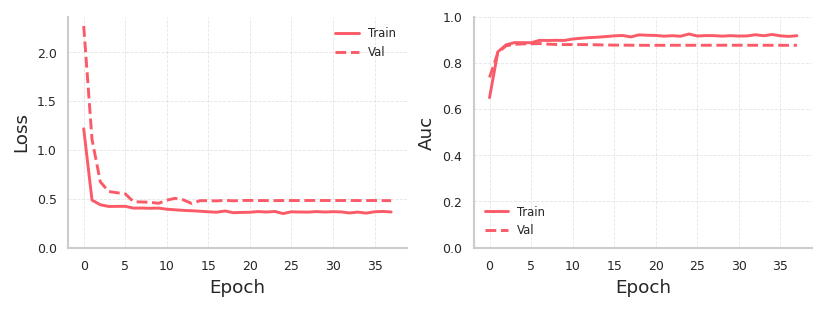

In [43]:
plot_metrics(resampled_history)

#### Evaluate Model:

In [45]:
train_predictions_resampled = model.predict(dataset_train)
valid_predictions_resampled = model.predict(dataset_validation)
test_predictions_resampled = model.predict(dataset_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Legitimate Transactions Detected (True Negatives):  95
Legitimate Transactions Incorrectly Detected (False Positives):  21
Fraudulent Transactions Missed (False Negatives):  57
Fraudulent Transactions Detected (True Positives):  186
Total Fraudulent Transactions:  243


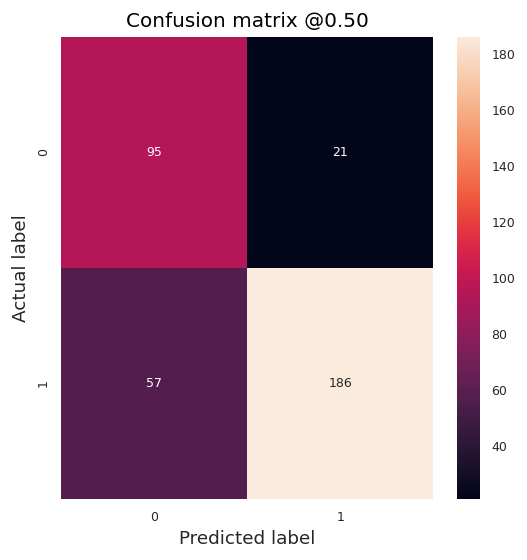

In [46]:
plot_cm(y_valid, valid_predictions_resampled)

Legitimate Transactions Detected (True Negatives):  95
Legitimate Transactions Incorrectly Detected (False Positives):  21
Fraudulent Transactions Missed (False Negatives):  57
Fraudulent Transactions Detected (True Positives):  186
Total Fraudulent Transactions:  243


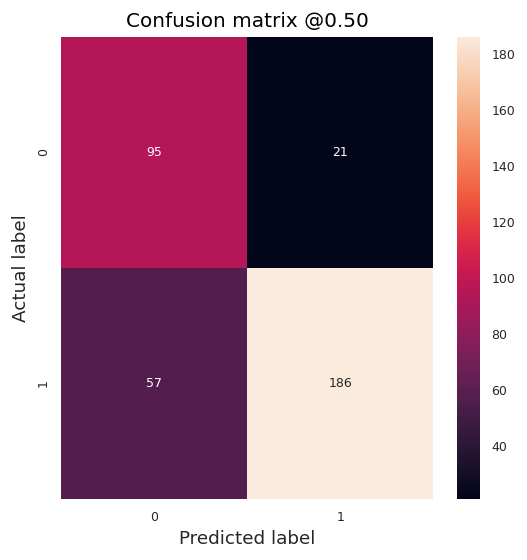

In [47]:
plot_cm(y_valid, valid_predictions_resampled)

In [48]:
df_subm["rainfall"] = test_predictions_resampled
df_subm.to_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E3/submission_lstm_tab_v0_all_data.csv")

In [ ]:
y_valid[:10]

array([0, 0, 1, 1, 0, 0, 1, 1, 1, 1])

In [ ]:
validation.head(10)

,pressure,temparature,dewpoint,humidity,cloud,sunshine,Wdsx,Wdsy,Year_sin,Year_cos,sem_sin,sem_cos,m4_sin,m4_cos,m6_sin,m6_cos,m8_sin,m8_cos,temp_diff,dewpoint_spread,range_dist_cloud,cloud_Humidity_Interaction,rainfall
0,1.452458,-0.951179,-0.887351,-0.094115,0.424955,-0.881182,0.347721,0.202977,0.034422,0.999407,0.068802,0.997630,0.103102,0.994671,0.205104,0.978740,0.271958,0.962309,0.187783,-0.121217,0.607652,0.519015,1
1,1.053707,-0.875442,-0.368423,1.616306,0.853347,-1.044309,0.416607,0.038796,0.051620,0.998667,0.103102,0.994671,0.154309,0.988023,0.304921,0.952378,0.401488,0.915864,-1.237624,-1.355594,-0.394800,1.781525,1
2,0.915012,-0.629297,-0.294290,1.005441,0.692700,-0.772430,0.415635,0.280586,0.068802,0.997630,0.137279,0.990532,0.205104,0.978740,0.401488,0.915864,0.523416,0.852078,-0.654504,-0.892702,0.086081,0.262796,1
3,0.394898,-0.610362,-0.090425,1.616306,0.317858,-1.044309,0.391314,0.018445,0.085965,0.996298,0.171293,0.985220,0.255353,0.966848,0.493776,0.869589,0.635432,0.772157,-2.015120,-1.407026,-1.386769,1.709152,1
4,0.897668,-0.572494,-0.442555,0.272404,-1.288609,1.049159,0.598051,-0.225140,0.103102,0.994671,0.205104,0.978740,0.304921,0.952378,0.580800,0.814046,0.735417,0.677615,0.576529,-0.326946,-0.879598,-0.976980,1
5,1.417782,-0.970113,-0.998551,-0.338461,-1.020865,-0.119920,0.927827,0.141527,0.120208,0.992749,0.238673,0.971100,0.353676,0.935368,0.661635,0.749826,0.821477,0.570242,0.122992,0.135945,-0.834876,-0.610788,0
6,1.244411,-1.045850,-1.109750,-0.460634,-2.520234,1.049159,0.170442,0.245001,0.137279,0.990532,0.271958,0.962309,0.401488,0.915864,0.735417,0.677615,0.891981,0.452072,0.187783,0.238811,-1.696128,-1.112336,0
7,1.209734,-1.102652,-1.128283,-0.460634,0.210760,-0.147108,0.585890,1.799233,0.154309,0.988023,0.304921,0.952378,0.448229,0.893919,0.801361,0.598181,0.945596,0.325342,-1.561580,0.135946,-1.049938,-0.447891,0
8,0.672288,-1.121587,-0.905885,0.394577,0.853347,-1.044309,0.549754,1.704031,0.171293,0.985220,0.337523,0.941317,0.493776,0.869589,0.858764,0.512371,0.981306,0.192452,-1.885537,-0.532676,-1.089225,1.785597,1
9,0.498917,-1.102652,-0.739086,1.005441,0.799798,-0.473363,0.876934,0.409176,0.188227,0.982126,0.369725,0.929141,0.538005,0.842942,0.907014,0.421101,0.998435,0.055917,-0.200965,-0.944134,0.657086,-0.146131,1


In [ ]:
train.head(10)

,pressure,temparature,dewpoint,humidity,cloud,sunshine,Wdsx,Wdsy,Year_sin,Year_cos,sem_sin,sem_cos,m4_sin,m4_cos,m6_sin,m6_cos,m8_sin,m8_cos,temp_diff,dewpoint_spread,range_dist_cloud,cloud_Humidity_Interaction,rainfall
0,0.654955,-0.629297,-0.183091,0.638922,0.692700,-0.745242,0.266192,0.404027,0.017213,0.999852,0.034422,0.999407,0.051620,0.998667,0.103102,0.994671,0.137279,0.990532,-1.885535,-1.201297,-1.147765,0.202762,1
1,1.019030,-1.329863,-0.924418,1.616306,0.853347,-1.044309,0.627866,0.523115,0.034422,0.999407,0.068802,0.997630,0.103102,0.994671,0.205104,0.978740,0.271958,0.962309,-2.468657,-1.047000,-1.714207,1.785597,1
2,1.816533,-1.481337,-2.054941,-0.827153,-1.502805,1.212287,0.107086,0.537809,0.051620,0.998667,0.103102,0.994671,0.154309,0.988023,0.304921,0.952378,0.401488,0.915864,0.382156,1.678918,-1.102818,-1.006968,1
3,-0.038530,-1.159455,-0.664954,1.616306,1.067542,-1.044309,0.873709,1.413020,0.068802,0.997630,0.137279,0.990532,0.205104,0.978740,0.401488,0.915864,0.523416,0.852078,-1.950327,-1.304162,-1.083799,1.808886,1
4,1.417782,-1.045850,-1.999341,-3.637131,-1.609903,-0.065545,0.952812,0.470228,0.085965,0.996298,0.171293,0.985220,0.255353,0.966848,0.493776,0.869589,0.635432,0.772157,1.224442,2.707566,-0.956126,-0.701745,0
5,1.573820,-1.007981,-1.461880,-0.338461,0.317858,-1.044309,0.672513,-0.199152,0.103102,0.994671,0.205104,0.978740,0.304921,0.952378,0.580800,0.814046,0.735417,0.677615,-0.071382,1.318891,0.263802,1.736545,1
6,1.591153,-1.045850,-1.684278,-3.148439,-1.556354,1.021972,1.460575,0.075888,0.120208,0.992749,0.238673,0.971100,0.353676,0.935368,0.661635,0.749826,0.821477,0.570242,-0.006591,1.833215,-1.246718,-0.992682,0
7,1.053707,-1.954693,-1.591612,1.738479,1.335287,-1.044309,1.939451,2.021943,0.137279,0.990532,0.271958,0.962309,0.401488,0.915864,0.735417,0.677615,0.891981,0.452072,-0.719294,-0.892702,0.607610,1.846465,1
8,0.654955,-1.405600,-1.461880,0.516749,1.335287,-1.044309,1.290025,1.279805,0.154309,0.988023,0.304921,0.952378,0.448229,0.893919,0.801361,0.598181,0.945596,0.325342,-1.431998,0.238811,-0.314825,1.853866,1
9,2.041924,-1.803219,-2.184673,-0.582807,0.478504,-0.772430,1.323982,1.318610,0.171293,0.985220,0.337523,0.941317,0.493776,0.869589,0.858764,0.512371,0.981306,0.192452,0.187783,1.164594,0.670671,0.254367,0
